In [13]:
import os
import json
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go

import random
import re
from typing import Dict



import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# from src.visualisation import seen_mit_sterbejahr, seen_mit_sterbejahr_single, get_death_year

import src.visualisation as vz


In [14]:
# Farben und Labels für Szenarien
farben = {"RCP26": "#2ca02c", "RCP45": "#ff9900", "RCP85": "#e41a1c"}
labels = {"RCP26": "Optimistisches Szenario", "RCP45": "Mittleres Szenario", "RCP85": "Pessimistisches Szenario"}


## Daten aufbereiten

### Klimaszenarien je See einlesen

In [15]:
# Ordner mit deinen JSON-Dateien
pfad_zum_ordner = "../data/see_data_json"  # oder einfach dein Upload-Ordner

# Liste aller Dateinamen (z. B. ["Maggiore.json", "Zugersee.json", ...])
dateien = [f for f in os.listdir(pfad_zum_ordner) if f.endswith(".json")]

# Funktion wie vorher
def extract_scenario_with_depth(data, depth, scenario, lake_name):
    d = data['yearly'][depth][scenario]
    df = pd.DataFrame({
        "year": d["x"],
        "temperature_avg": d["y_ave"],
        "temperature_min": d["y_min"],
        "temperature_max": d["y_max"],
        "scenario": scenario,
        "depth": depth,
        "lake": lake_name
    })
    return df

# Alle Seen & Szenarien kombinieren
alle_dfs = []
for datei in dateien:
    lake_name = datei.replace(".json", "")
    with open(os.path.join(pfad_zum_ordner, datei), "r") as f:
        data = json.load(f)
        for depth in ["surface", "bottom"]:
            for scenario in ["RCP26", "RCP45", "RCP85"]:
                df = extract_scenario_with_depth(data, depth, scenario, lake_name)
                alle_dfs.append(df)

df_alle_seen = pd.concat(alle_dfs, ignore_index=True)

df_alle_seen

year  temperature_avg  temperature_min  temperature_max scenario  \
0      1981            11.15            10.58            11.72    RCP26   
1      1982            11.81            11.31            12.10    RCP26   
2      1983            11.33            10.66            12.07    RCP26   
3      1984            11.07            10.16            11.32    RCP26   
4      1985            11.31            10.68            11.91    RCP26   
...     ...              ...              ...              ...      ...   
20701  2095             8.94             7.91             9.85    RCP85   
20702  2096             9.20             8.35            10.31    RCP85   
20703  2097             9.23             8.34            10.75    RCP85   
20704  2098             9.69             8.07            11.45    RCP85   
20705  2099             9.74             8.44            10.77    RCP85   

         depth   lake  
0      surface   Biel  
1      surface   Biel  
2      surface   Biel  
3      surface   Biel  
4      surface   Biel  
...        ...    ...  
20701   bottom  Walen  
20702   bottom  Walen  
20703   bottom  Walen  
20704   bottom  Walen  
20705   bottom  Walen  

[20706 rows x 7 columns]

In [16]:
lake_rename = {
    'Biel': 'Bielersee',
    'Brienz': 'Brienzersee',
    'Geneva': 'Genfersee',
    'Greifen': 'Greifensee',
    'Joux': 'Lac de Joux',
    'Klontaler': 'Klöntalersee',
    'LacdelHongrin': "Lac de l'Hongrin",
    'LakeDavos': 'Davosersee',
    'Lower-Constance': 'Untersee (Bodensee)',
    'Lower-Lugano': 'Unterer Luganersee',
    'Lower-Zurich': 'Unterer Zürichsee',
    'Lucerne-Alpnacher': 'Alpnachersee',
    'Lucerne-Gersauer': 'Vierwaldstättersee (Gersauer Becken)',
    'Lucerne-Kreuztrichter': 'Vierwaldstättersee (Kreuztrichter)',
    'Lucerne-Urnersee': 'Vierwaldstättersee (Urnersee)',
    'Maggiore': 'Lago Maggiore',
    'Murten': 'Murtensee',
    'Neuchatel': 'Neuenburgersee',
    'Oeschinensee': 'Oeschinensee',
    'Pfaffikon': 'Pfäffikersee',
    'Poschiavo': 'Poschiavosee',
    'Rot': 'Rotsee',
    'Sils': 'Silsersee',
    'Silvaplana': 'Silvaplanersee',
    'StMoritz': 'St. Moritzersee',
    'Upper-Constance': 'Obersee (Bodensee)',
    'Upper-Lugano': 'Oberer Luganersee',
    'Upper-Zurich': 'Oberer Zürichsee',
    'Walen': 'Walensee'
}


df_alle_seen['lake'] = df_alle_seen['lake'].map(lake_rename)
df_alle_seen


year  temperature_avg  temperature_min  temperature_max scenario  \
0      1981            11.15            10.58            11.72    RCP26   
1      1982            11.81            11.31            12.10    RCP26   
2      1983            11.33            10.66            12.07    RCP26   
3      1984            11.07            10.16            11.32    RCP26   
4      1985            11.31            10.68            11.91    RCP26   
...     ...              ...              ...              ...      ...   
20701  2095             8.94             7.91             9.85    RCP85   
20702  2096             9.20             8.35            10.31    RCP85   
20703  2097             9.23             8.34            10.75    RCP85   
20704  2098             9.69             8.07            11.45    RCP85   
20705  2099             9.74             8.44            10.77    RCP85   

         depth       lake  
0      surface  Bielersee  
1      surface  Bielersee  
2      surface  Bielersee  
3      surface  Bielersee  
4      surface  Bielersee  
...        ...        ...  
20701   bottom   Walensee  
20702   bottom   Walensee  
20703   bottom   Walensee  
20704   bottom   Walensee  
20705   bottom   Walensee  

[20706 rows x 7 columns]

In [17]:
len(df_alle_seen["lake"].unique())

29

### Fisch Daten einlesen

In [19]:
#Fischdaten einlesen
df_fisch = pd.read_csv("../data/Fischdaten.csv")
df_fisch

Name deutsch/lokal        Name wissenschaftlich  \
0           Atlantischer Stor             Acipenser sturio   
1                         Aal            Anguilla anguilla   
2                    Cagnetta          Salaria fluviatilis   
3                       Agone                  Alosa agone   
4                    Maifisch                  Alosa alosa   
..                        ...                          ...   
70  Italienischer Dohlenkrebs    Austropotamobius italicus   
71                Dohlenkrebs    Austropotamobius pallipes   
72                 Steinkrebs  Austropotamobius torrentium   
73                  Edelkrebs              Astacus astacus   
74      Sanguinerola italiana           Phoxinus lumaireul   

                   Einzugsgebiet Gefährdungsstatus L. Maggiore  \
0                      Hochrhein                 0        NEIN   
1    Rhein, Rhone, Doubs, Ticino                 1          JA   
2                         Ticino                 3          JA   
3                         Ticino                 3          JA   
4                      Hochrhein                 0        NEIN   
..                           ...               ...         ...   
70          Rhein, Rhone, Ticino                 1          JA   
71  Rhein, Rhone, Doubs, Ticiono                 2        NEIN   
72                         Rhein                 2        NEIN   
73      Rhein, Rhone, Doubs, Inn                 3        NEIN   
74                        Ticino                 3          JA   

   Lower L. Lugano Upper L. Lugano L. Geneva Lower L. Constance  \
0             NEIN            NEIN      NEIN               NEIN   
1               JA              JA        JA                 JA   
2               JA              JA      NEIN               NEIN   
3               JA              JA      NEIN               NEIN   
4             NEIN            NEIN      NEIN               NEIN   
..             ...             ...       ...                ...   
70              JA              JA        JA               NEIN   
71            NEIN            NEIN      NEIN               NEIN   
72            NEIN            NEIN      NEIN               NEIN   
73            NEIN            NEIN      NEIN               NEIN   
74              JA              JA      NEIN               NEIN   

   Upper L. Constance  ... Lac de Joux Lac de l'Hongrin L. Davos Oeschinensee  \
0                NEIN  ...        NEIN             NEIN     NEIN         NEIN   
1                  JA  ...          JA               JA       JA           JA   
2                NEIN  ...        NEIN             NEIN     NEIN         NEIN   
3                NEIN  ...        NEIN             NEIN     NEIN         NEIN   
4                NEIN  ...        NEIN             NEIN     NEIN         NEIN   
..                ...  ...         ...              ...      ...          ...   
70               NEIN  ...          JA               JA     NEIN         NEIN   
71               NEIN  ...        NEIN             NEIN     NEIN         NEIN   
72               NEIN  ...        NEIN             NEIN     NEIN         NEIN   
73               NEIN  ...        NEIN             NEIN     NEIN         NEIN   
74               NEIN  ...        NEIN             NEIN     NEIN         NEIN   

   L. St. Moritz L. Silvaplana L. Sils Kritische Temperatur °C  \
0           NEIN          NEIN    NEIN                      29   
1           NEIN          NEIN    NEIN                      35   
2           NEIN          NEIN    NEIN                       X   
3           NEIN          NEIN    NEIN                       X   
4           NEIN          NEIN    NEIN                       X   
..           ...           ...     ...                     ...   
70          NEIN          NEIN    NEIN                      25   
71          NEIN          NEIN    NEIN                       X   
72          NEIN          NEIN    NEIN                      21   
73          NEIN          NEIN     

In [20]:
#Spaltennamen Fischdaten auf gängige Seenamen ändern
rename_dict = {
    'Name deutsch/lokal': 'Fisch',
    "L. Maggiore": "Lago Maggiore",
    "Lower L. Lugano": "Unterer Luganersee",
    "Upper L. Lugano": "Oberer Luganersee",
    'L. Geneva': "Genfersee",
    'Lower L. Constance': "Untersee (Bodensee)",
    'Upper L. Constance': "Obersee (Bodensee)",
    'Upper L. Zürich': "Oberer Zürichsee",
    'Lower L. Zürich': "Unterer Zürichsee",
    'Walensee': "Walensee",
    'Rotsee': "Rotsee",
    'L. Biel': "Bielersee",
    'L. Murten': "Murtensee",
    'L. Neuchâtel': "Neuenburgersee",
    'L. Alpnach': "Alpnachersee",
    'L. Lucerne, Gersauer Becken': 'Vierwaldstättersee (Gersauer Becken)',
    'L. Lucerne, Kreuztrichter': 'Vierwaldstättersee (Kreuztrichter)',
    'L. Lucerne, Urnersee': 'Vierwaldstättersee (Urnersee)',
    'Greifensee': "Greifensee",
    'Pfäffikersee': 'Pfäffikersee',
    'L. Brienz': 'Brienzersee',
    'Klöntalersee': 'Klöntalersee',
    'Lago di Poschiavo': 'Poschiavosee',
    'Lac de Joux': 'Lac de Joux',
    "Lac de l'Hongrin": "Lac de l'Hongrin",
    'L. Davos': 'Davosersee',
    'Oeschinensee': 'Oeschinensee',
    'L. St. Moritz': 'St. Moritzersee',
    'L. Silvaplana': 'Silvaplanersee',
    'L. Sils': "Silsersee"
}

# DataFrame df umbenennen
df_fisch = df_fisch.rename(columns=rename_dict)


df_fisch

Fisch        Name wissenschaftlich  \
0           Atlantischer Stor             Acipenser sturio   
1                         Aal            Anguilla anguilla   
2                    Cagnetta          Salaria fluviatilis   
3                       Agone                  Alosa agone   
4                    Maifisch                  Alosa alosa   
..                        ...                          ...   
70  Italienischer Dohlenkrebs    Austropotamobius italicus   
71                Dohlenkrebs    Austropotamobius pallipes   
72                 Steinkrebs  Austropotamobius torrentium   
73                  Edelkrebs              Astacus astacus   
74      Sanguinerola italiana           Phoxinus lumaireul   

                   Einzugsgebiet Gefährdungsstatus Lago Maggiore  \
0                      Hochrhein                 0          NEIN   
1    Rhein, Rhone, Doubs, Ticino                 1            JA   
2                         Ticino                 3            JA   
3                         Ticino                 3            JA   
4                      Hochrhein                 0          NEIN   
..                           ...               ...           ...   
70          Rhein, Rhone, Ticino                 1            JA   
71  Rhein, Rhone, Doubs, Ticiono                 2          NEIN   
72                         Rhein                 2          NEIN   
73      Rhein, Rhone, Doubs, Inn                 3          NEIN   
74                        Ticino                 3            JA   

   Unterer Luganersee Oberer Luganersee Genfersee Untersee (Bodensee)  \
0                NEIN              NEIN      NEIN                NEIN   
1                  JA                JA        JA                  JA   
2                  JA                JA      NEIN                NEIN   
3                  JA                JA      NEIN                NEIN   
4                NEIN              NEIN      NEIN                NEIN   
..                ...               ...       ...                 ...   
70                 JA                JA        JA                NEIN   
71               NEIN              NEIN      NEIN                NEIN   
72               NEIN              NEIN      NEIN                NEIN   
73               NEIN              NEIN      NEIN                NEIN   
74                 JA                JA      NEIN                NEIN   

   Obersee (Bodensee)  ... Lac de Joux Lac de l'Hongrin Davosersee  \
0                NEIN  ...        NEIN             NEIN       NEIN   
1                  JA  ...          JA               JA         JA   
2                NEIN  ...        NEIN             NEIN       NEIN   
3                NEIN  ...        NEIN             NEIN       NEIN   
4                NEIN  ...        NEIN             NEIN       NEIN   
..                ...  ...         ...              ...        ...   
70               NEIN  ...          JA               JA       NEIN   
71               NEIN  ...        NEIN             NEIN       NEIN   
72               NEIN  ...        NEIN             NEIN       NEIN   
73               NEIN  ...        NEIN             NEIN       NEIN   
74               NEIN  ...        NEIN             NEIN       NEIN   

   Oeschinensee St. Moritzersee Silvaplanersee Silsersee  \
0          NEIN            NEIN           NEIN      NEIN   
1            JA            NEIN           NEIN      NEIN   
2          NEIN            NEIN           NEIN      NEIN   
3          NEIN            NEIN           NEIN      NEIN   
4          NEIN            NEIN           NEIN      NEIN   
..          ...             ...            ...       ...   
70         NEIN            NEIN           NEIN      NEIN   
71         NEIN            NEIN           NEIN      NEIN   
72         NEIN            NEIN           NEIN      NEIN   
73         NEIN            NEIN           NEIN        JA   
74         NEIN              JA             JA      NEIN   

   Kritische Temperatur

In [21]:
# Count the number of distinct fish
distinct_fish_count = df_fisch['Fisch'].nunique()

# Display the result
print(f"Anzahl der verschiedenen Fischarten: {distinct_fish_count}")

Anzahl der verschiedenen Fischarten: 75


In [22]:
# Schritt 1: Fischdaten vorbereiten (long-format)
id_vars = ['Fisch', 'Name wissenschaftlich', 'Einzugsgebiet', 'Gefährdungsstatus']
exclude = ['Kritische Temperatur °C', 'Minimale Temperatur °C', 'Kritischer O2-Grenzwert (mg/l)']
value_vars = [col for col in df_fisch.columns if col not in id_vars + exclude]

df_fisch_long = df_fisch.melt(
    id_vars=id_vars + exclude,
    value_vars=value_vars,
    var_name='lake',
    value_name='present'
)


# Count the number of distinct fish
distinct_fish_count = df_fisch_long['Fisch'].nunique()

# Display the result
print(f"Anzahl der verschiedenen Fischarten: {distinct_fish_count}")

########################### anschauen SA #####################
# bei den fischen die keinen 

# Nur Fische, die in einem See vorkommen
df_fisch_long = df_fisch_long[df_fisch_long['present'] == 'JA'].drop(columns='present')

df_fisch_long

Anzahl der verschiedenen Fischarten: 75


Fisch Name wissenschaftlich                Einzugsgebiet  \
1                 Aal     Anguilla anguilla  Rhein, Rhone, Doubs, Ticino   
2            Cagnetta   Salaria fluviatilis                       Ticino   
3               Agone           Alosa agone                       Ticino   
5             Cheppia          Alosa fallax                       Ticino   
6     Cobite italiano       Cobite italiano                       Ticino   
...               ...                   ...                          ...   
2154           Huchen           Hucho hucho                          Inn   
2156     Donauforelle          Salmo labrax                          Inn   
2160      Bachforelle    Salmo trutta fario            Rhein, Rhone, Inn   
2169            Asche   Thymallus thymallus     Rhein, Rhone, Doubs, Inn   
2173        Edelkrebs       Astacus astacus     Rhein, Rhone, Doubs, Inn   

     Gefährdungsstatus Kritische Temperatur °C Minimale Temperatur °C  \
1                    1                      35                      X   
2                    3                       X                      3   
3                    3                       X                      6   
5                   DU                      18                      0   
6                    2                       X                      3   
...                ...                     ...                    ...   
2154                 0                      23                      3   
2156                 1                       X                      1   
2160                 4                      19                      X   
2169                 2                      21                      8   
2173                 3                      16                      5   

      Kritischer O2-Grenzwert (mg/l)           lake  
1                                2.5  Lago Maggiore  
2                                4.0  Lago Maggiore  
3                                4.5  Lago Maggiore  
5                                3.5  Lago Maggiore  
6                                3.0  Lago Maggiore  
...                              ...            ...  
2154                             3.0      Silsersee  
2156                             3.0      Silsersee  
2160                             3.0      Silsersee  
2169                             3.0      Silsersee  
2173                             3.0      Silsersee  

[658 rows x 8 columns]

In [23]:
# Count the number of distinct fish
distinct_fish_count = df_fisch_long['Fisch'].nunique()

# Display the result
print(f"Anzahl der verschiedenen Fischarten: {distinct_fish_count}")

Anzahl der verschiedenen Fischarten: 50


In [24]:
print("Seen in df_alle_seen:", sorted(df_alle_seen['lake'].unique()))
print("Seen in df_fisch_long:", sorted(df_fisch_long['lake'].unique()))


Seen in df_alle_seen: ['Alpnachersee', 'Bielersee', 'Brienzersee', 'Davosersee', 'Genfersee', 'Greifensee', 'Klöntalersee', 'Lac de Joux', "Lac de l'Hongrin", 'Lago Maggiore', 'Murtensee', 'Neuenburgersee', 'Oberer Luganersee', 'Oberer Zürichsee', 'Obersee (Bodensee)', 'Oeschinensee', 'Pfäffikersee', 'Poschiavosee', 'Rotsee', 'Silsersee', 'Silvaplanersee', 'St. Moritzersee', 'Unterer Luganersee', 'Unterer Zürichsee', 'Untersee (Bodensee)', 'Vierwaldstättersee (Gersauer Becken)', 'Vierwaldstättersee (Kreuztrichter)', 'Vierwaldstättersee (Urnersee)', 'Walensee']
Seen in df_fisch_long: ['Alpnachersee', 'Bielersee', 'Brienzersee', 'Davosersee', 'Genfersee', 'Greifensee', 'Klöntalersee', 'Lac de Joux', "Lac de l'Hongrin", 'Lago Maggiore', 'Murtensee', 'Neuenburgersee', 'Oberer Luganersee', 'Oberer Zürichsee', 'Obersee (Bodensee)', 'Oeschinensee', 'Pfäffikersee', 'Poschiavosee', 'Rotsee', 'Silsersee', 'Silvaplanersee', 'St. Moritzersee', 'Unterer Luganersee', 'Unterer Zürichsee', 'Untersee (

In [25]:
# Fischdaten mit den Seedaten kombinieren
# df_alle_seen sollte enthalten: lake, year, scenario, depth, temperature_max etc.
df_merged = pd.merge(df_fisch_long, df_alle_seen, on='lake', how='inner')

# Kritische Temperatur als float
df_merged['Kritische Temperatur °C'] = pd.to_numeric(df_merged['Kritische Temperatur °C'], errors='coerce')

# Überlebensstatus berechnen
df_merged['überlebt'] = df_merged['temperature_max'] < df_merged['Kritische Temperatur °C']

# Ergebnis anzeigen
df_merged

# df_merged.to_csv("../data/df_merged.csv", index=False)

Fisch Name wissenschaftlich                Einzugsgebiet  \
0             Aal     Anguilla anguilla  Rhein, Rhone, Doubs, Ticino   
1             Aal     Anguilla anguilla  Rhein, Rhone, Doubs, Ticino   
2             Aal     Anguilla anguilla  Rhein, Rhone, Doubs, Ticino   
3             Aal     Anguilla anguilla  Rhein, Rhone, Doubs, Ticino   
4             Aal     Anguilla anguilla  Rhein, Rhone, Doubs, Ticino   
...           ...                   ...                          ...   
469807  Edelkrebs       Astacus astacus     Rhein, Rhone, Doubs, Inn   
469808  Edelkrebs       Astacus astacus     Rhein, Rhone, Doubs, Inn   
469809  Edelkrebs       Astacus astacus     Rhein, Rhone, Doubs, Inn   
469810  Edelkrebs       Astacus astacus     Rhein, Rhone, Doubs, Inn   
469811  Edelkrebs       Astacus astacus     Rhein, Rhone, Doubs, Inn   

       Gefährdungsstatus  Kritische Temperatur °C Minimale Temperatur °C  \
0                      1                     35.0                      X   
1                      1                     35.0                      X   
2                      1                     35.0                      X   
3                      1                     35.0                      X   
4                      1                     35.0                      X   
...                  ...                      ...                    ...   
469807                 3                     16.0                      5   
469808                 3                     16.0                      5   
469809                 3                     16.0                      5   
469810                 3                     16.0                      5   
469811                 3                     16.0                      5   

        Kritischer O2-Grenzwert (mg/l)           lake  year  temperature_avg  \
0                                  2.5  Lago Maggiore  1981            11.73   
1                                  2.5  Lago Maggiore  1982            11.87   
2                                  2.5  Lago Maggiore  1983            11.92   
3                                  2.5  Lago Maggiore  1984            11.51   
4                                  2.5  Lago Maggiore  1985            11.97   
...                                ...            ...   ...              ...   
469807                             3.0      Silsersee  2095             4.48   
469808                             3.0      Silsersee  2096             4.74   
469809                             3.0      Silsersee  2097             4.62   
469810                             3.0      Silsersee  2098             4.88   
469811                             3.0      Silsersee  2099             5.01   

        temperature_min  temperature_max scenario    depth  überlebt  
0                 11.20            12.31    RCP26  surface      True  
1                 11.56            12.39    RCP26  surface      True  
2                 11.68            12.32    RCP26  surface      True  
3                 10.75            12.33    RCP26  surface      True  
4                 11.53            12.37    RCP26  surface      True  
...                 ...              ...      ...      ...       ...  
469807             4.10             5.09    RCP85   bottom      True  
469808             4.36             4.94    RCP85   bottom      True  
469809             4.15             5.23    RCP85   bottom      True  
469810             4.17             5.71    RCP85   bottom      True  
469811             4.20             5.53    RCP85   bottom      True  

[469812 rows x 15 columns]

## Alle Fische

### Anzahl Fische je See

In [26]:
fische_je_see = df_merged.groupby("lake")["Fisch"].nunique().reset_index()
fische_je_see.columns = ["lake", "Anzahl Fische"]

fische_je_see

lake  Anzahl Fische
0                           Alpnachersee             26
1                              Bielersee             26
2                            Brienzersee             26
3                             Davosersee             26
4                              Genfersee             20
5                             Greifensee             26
6                           Klöntalersee             26
7                            Lac de Joux             20
8                       Lac de l'Hongrin             20
9                          Lago Maggiore             24
10                             Murtensee             20
11                        Neuenburgersee             20
12                     Oberer Luganersee             24
13                      Oberer Zürichsee             27
14                    Obersee (Bodensee)             26
15                          Oeschinensee             26
16                          Pfäffikersee             26
17                          Poschiavosee              9
18                                Rotsee             26
19                             Silsersee             13
20                        Silvaplanersee             10
21                       St. Moritzersee             10
22                    Unterer Luganersee             24
23                     Unterer Zürichsee             26
24                   Untersee (Bodensee)             26
25  Vierwaldstättersee (Gersauer Becken)             26
26    Vierwaldstättersee (Kreuztrichter)             26
27         Vierwaldstättersee (Urnersee)             26
28                              Walensee             27

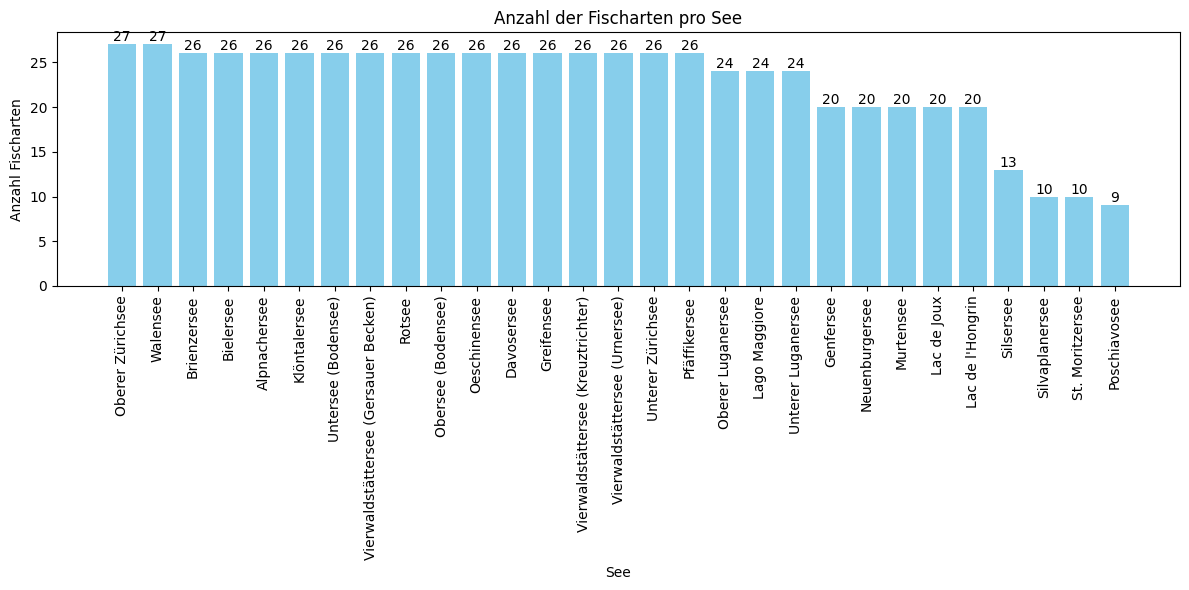

In [27]:
# Barplot für die Anzahl der Fische pro See (absteigend sortiert)
fische_je_see_sorted = fische_je_see.sort_values(by='Anzahl Fische', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(fische_je_see_sorted['lake'], fische_je_see_sorted['Anzahl Fische'], color='skyblue')

# Summe oberhalb der Bars anzeigen
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Anzahl der Fischarten pro See')
plt.xlabel('See')
plt.ylabel('Anzahl Fischarten')
plt.tight_layout()
plt.show()

### Anzahl Seen je Fisch

In [28]:
# 1. Group by Fisch and count unique lakes
df_fisch_je_see = df_merged.groupby("Fisch")["lake"].nunique().reset_index()

# 2. Rename columns for clarity
df_fisch_je_see.columns = ["Fisch", "Anzahl Seen"]

# 3. Sort by the number of lakes in descending order
df_fisch_je_see = df_fisch_je_see.sort_values("Anzahl Seen", ascending=False)

df_fisch_je_see

Fisch  Anzahl Seen
15                    Cheppia           29
24                     Groppe           29
42                    Schleie           29
39                   Rotfeder           26
20                    Elritze           26
43      Schmerle, Bartgrundel           26
6                 Bachforelle           26
0                         Aal           25
49                     Trügen           25
25                  Gründling           25
30                    Karpfen           25
13                  Brachsmen           22
8                       Barbe           22
26                      Hasel           22
44                  Schneider           22
38                    Rotauge           22
48                    Stromer           22
32              Laube, Ukelei           22
31                 Kaulbarsch           22
36                       Nase           17
12                     Blicke           17
7                Bachneunauge           17
11                 Bitterling           17
46  Steinbeisser, Dorngrundel           17
34                Meerforelle           17
35              Moderlieschen           17
29  Italienischer Dohlenkrebs            8
40      Sanguinerola italiana            5
28                     Huchen            4
18               Donauforelle            4
2         Adriatische Forelle            3
1          Adriatische Aesche            3
9                       Barbo            3
10               Barbo canino            3
41                    Savetta            3
17          Cobite mascherato            3
14                   Cagnetta            3
16            Cobite italiano            3
3                       Agone            3
4                   Alborella            3
23                    Ghiozzo            3
33           Marmorataforelle            3
45          Siidlicher Hecht             3
37                       Pigo            3
47                  Strigione            3
22               Flussforelle            2
5                       Asche            1
27                      Hecht            1
21          Flussbarsch, Egli            1
19                  Edelkrebs            1

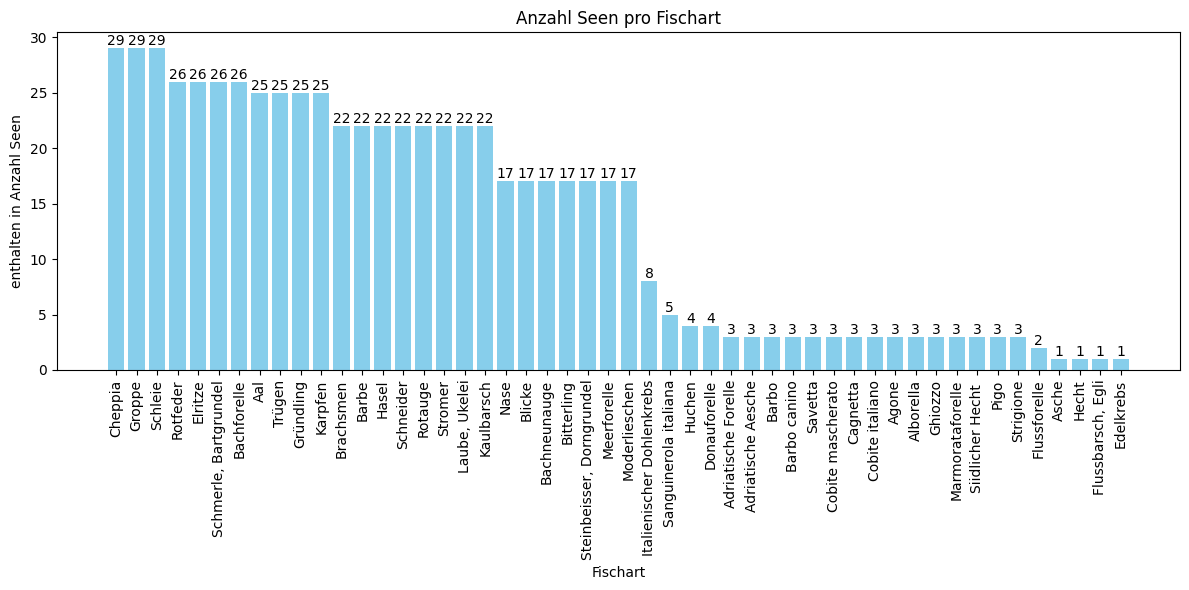

In [29]:
# Barplot für die Anzahl der Fische pro See (absteigend sortiert)
df_fisch_je_see_sorted = df_fisch_je_see.sort_values(by='Anzahl Seen', ascending=False)

plt.figure(figsize=(12, 6))
bars = plt.bar(df_fisch_je_see_sorted['Fisch'], df_fisch_je_see_sorted['Anzahl Seen'], color='skyblue')

# Summe oberhalb der Bars anzeigen
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom')

plt.xticks(rotation=90)
plt.title('Anzahl Seen pro Fischart')
plt.xlabel('Fischart')
plt.ylabel('enthalten in Anzahl Seen')
plt.tight_layout()
plt.show()

In [30]:
# #  Ensure 'genfer_see_fische' is defined before using it
genfer_see_fische = df_fisch_long[df_fisch_long['lake'] == 'Geneva']


top_10_fische = df_fisch_je_see_sorted.head(10)
top_10_fische['Im Genfer See'] = top_10_fische['Fisch'].apply(lambda fisch: 'JA' if fisch in genfer_see_fische['Fisch'].values else 'NEIN')

# Display the resulting DataFrame
top_10_fische[['Fisch', 'Anzahl Seen', 'Im Genfer See']]

C:\Users\Sandra\AppData\Local\Temp\ipykernel_18732\3037107820.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_10_fische['Im Genfer See'] = top_10_fische['Fisch'].apply(lambda fisch: 'JA' if fisch in genfer_see_fische['Fisch'].values else 'NEIN')


Fisch  Anzahl Seen Im Genfer See
15                Cheppia           29          NEIN
24                 Groppe           29          NEIN
42                Schleie           29          NEIN
39               Rotfeder           26          NEIN
20                Elritze           26          NEIN
43  Schmerle, Bartgrundel           26          NEIN
6             Bachforelle           26          NEIN
0                     Aal           25          NEIN
49                 Trügen           25          NEIN
25              Gründling           25          NEIN

## Szenarien - survival je fisch

In [31]:
# Count unique fish without a critical temperature value
fische_ohne_kritischer_o2 = df_merged[df_merged['Kritischer O2-Grenzwert (mg/l)'].isna()]['Fisch'].nunique()
fische_ohne_kritische_temp = df_merged[df_merged['Kritische Temperatur °C'].isna()]['Fisch'].nunique()

# Display the result
print(f"Anzahl der Fische ohne kritischen O2: {fische_ohne_kritischer_o2}")
print(f"Anzahl der Fische ohne kritische Temperatur: {fische_ohne_kritische_temp}")

# Count the number of distinct fish
distinct_fish_count = df_merged['Fisch'].nunique()

# Display the result
print(f"Anzahl der verschiedenen Fischarten: {distinct_fish_count}")

Anzahl der Fische ohne kritischen O2: 0
Anzahl der Fische ohne kritische Temperatur: 16
Anzahl der verschiedenen Fischarten: 50


In [32]:
df_survival = df_merged.groupby(["Fisch", "scenario"]).apply(vz.get_death_year).unstack(fill_value=0)

# Spaltennamen anpassen
df_survival.columns = [f"RCP{col[-2:]}" for col in df_survival.columns]

df_survival.reset_index(inplace=True)

# Ergänze die Spalte 'Frühstes Sterbejahr' mit dem frühesten Jahr aus den Szenarien
df_survival['Frühstes Sterbejahr'] = df_survival[['RCP26', 'RCP45', 'RCP85']].replace(0, float('inf')).min(axis=1)

# Kritischer O2-Wert und kritische Temperatur hinzufügen
df_survival = pd.merge(
    df_survival,
    df_merged[['Fisch', 'Kritischer O2-Grenzwert (mg/l)', 'Kritische Temperatur °C']].drop_duplicates(),
    on='Fisch',
    how='left'
)

df_survival['Frühstes Sterbejahr'] = df_survival['Frühstes Sterbejahr'].replace(float('inf'), 0)
df_survival

C:\Users\Sandra\AppData\Local\Temp\ipykernel_18732\4234194866.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_survival = df_merged.groupby(["Fisch", "scenario"]).apply(vz.get_death_year).unstack(fill_value=0)


Fisch  RCP26  RCP45  RCP85  Frühstes Sterbejahr  \
0                         Aal      0      0      0                  0.0   
1          Adriatische Aesche      0      0   2081               2081.0   
2         Adriatische Forelle   2024   2044   2029               2024.0   
3                       Agone   1981   1981   1981               1981.0   
4                   Alborella   1981   1981   1981               1981.0   
5                       Asche      0      0      0                  0.0   
6                 Bachforelle      0      0   2098               2098.0   
7                Bachneunauge      0      0   2069               2069.0   
8                       Barbe      0      0      0                  0.0   
9                       Barbo      0      0      0                  0.0   
10               Barbo canino      0      0      0                  0.0   
11                 Bitterling      0      0      0                  0.0   
12                     Blicke      0      0   2069               2069.0   
13                  Brachsmen      0      0      0                  0.0   
14                   Cagnetta   1981   1981   1981               1981.0   
15                    Cheppia      0      0   2081               2081.0   
16            Cobite italiano   1981   1981   1981               1981.0   
17          Cobite mascherato   2024   2044   2029               2024.0   
18               Donauforelle   1981   1981   1981               1981.0   
19                  Edelkrebs      0      0      0                  0.0   
20                    Elritze      0      0      0                  0.0   
21          Flussbarsch, Egli   1981   1981   1981               1981.0   
22               Flussforelle      0      0   2091               2091.0   
23                    Ghiozzo   1981   1981   1981               1981.0   
24                     Groppe   1981   1981   1981               1981.0   
25                  Gründling      0      0      0                  0.0   
26                      Hasel   1981   1981   1981               1981.0   
27                      Hecht      0      0      0                  0.0   
28                     Huchen      0      0      0                  0.0   
29  Italienischer Dohlenkrebs      0      0      0                  0.0   
30                    Karpfen   1981   1981   1981               1981.0   
31                 Kaulbarsch   2010   2011   2001               2001.0   
32              Laube, Ukelei      0      0      0                  0.0   
33           Marmorataforelle      0      0   2098               2098.0   
34                Meerforelle      0      0      0                  0.0   
35              Moderlieschen   1981   1981   1981               1981.0   
36                       Nase      0      0      0                  0.0   
37                       Pigo   2024   2044   2029               2024.0   
38                    Rotauge      0      0      0                  0.0   
39                   Rotfeder      0      0      0                  0.0   
40      Sanguinerola italiana      0      0      0                  0.0   
41                    Savetta   1981   1981   1981               1981.0   
42                    Schleie   1981   1981   1981               1981.0   
43      Schmerle, Bartgrundel   1981   1981   1981               1981.0   
44                  Schneider   1981   1981   1981               1981.0   
45          Siidlicher Hecht       0      0      0                  0.0   
46  Steinbeisser, Dorngrundel      0      0      0                  0.0   
47                  Strigione      0      0      0                  0.0   
48                    Stromer   1981   1981   1981               1981.0   
49                     Trügen   1992   1992   1992               1992.0   

    Kritischer O2-Grenzwert (mg/l)  Kritische Temperatur °C  
0                              2.5                     35.0  
1                              3.0                     18.0  
2           

In [33]:
fische_mit_sterbejahr = df_survival[df_survival['Frühstes Sterbejahr'] != 0]
fische_mit_sterbejahr

Fisch  RCP26  RCP45  RCP85  Frühstes Sterbejahr  \
1      Adriatische Aesche      0      0   2081               2081.0   
2     Adriatische Forelle   2024   2044   2029               2024.0   
3                   Agone   1981   1981   1981               1981.0   
4               Alborella   1981   1981   1981               1981.0   
6             Bachforelle      0      0   2098               2098.0   
7            Bachneunauge      0      0   2069               2069.0   
12                 Blicke      0      0   2069               2069.0   
14               Cagnetta   1981   1981   1981               1981.0   
15                Cheppia      0      0   2081               2081.0   
16        Cobite italiano   1981   1981   1981               1981.0   
17      Cobite mascherato   2024   2044   2029               2024.0   
18           Donauforelle   1981   1981   1981               1981.0   
21      Flussbarsch, Egli   1981   1981   1981               1981.0   
22           Flussforelle      0      0   2091               2091.0   
23                Ghiozzo   1981   1981   1981               1981.0   
24                 Groppe   1981   1981   1981               1981.0   
26                  Hasel   1981   1981   1981               1981.0   
30                Karpfen   1981   1981   1981               1981.0   
31             Kaulbarsch   2010   2011   2001               2001.0   
33       Marmorataforelle      0      0   2098               2098.0   
35          Moderlieschen   1981   1981   1981               1981.0   
37                   Pigo   2024   2044   2029               2024.0   
41                Savetta   1981   1981   1981               1981.0   
42                Schleie   1981   1981   1981               1981.0   
43  Schmerle, Bartgrundel   1981   1981   1981               1981.0   
44              Schneider   1981   1981   1981               1981.0   
48                Stromer   1981   1981   1981               1981.0   
49                 Trügen   1992   1992   1992               1992.0   

    Kritischer O2-Grenzwert (mg/l)  Kritische Temperatur °C  
1                              3.0                     18.0  
2                              3.0                     16.0  
3                              4.5                      NaN  
4                              3.0                      NaN  
6                              3.0                     19.0  
7                              3.0                     17.0  
12                             3.0                     17.0  
14                             4.0                      NaN  
15                             3.5                     18.0  
16                             3.0                      NaN  
17                             3.0                     16.0  
18                             3.0                      NaN  
21                             3.0                      NaN  
22                             3.0                     17.0  
23                             3.0                      NaN  
24                             3.0                      NaN  
26                             3.0                      NaN  
30                             3.0                      NaN  
31                             3.0                     15.0  
33                             3.0                     19.0  
35                             3.0                      NaN  
37                             3.0                     16.0  
41                             3.0                      NaN  
42                             3.0                      NaN  
43                             3.0                      NaN  
44                             3.0                      NaN  
48                             3.0                      NaN  
49                             3.0                     15.0

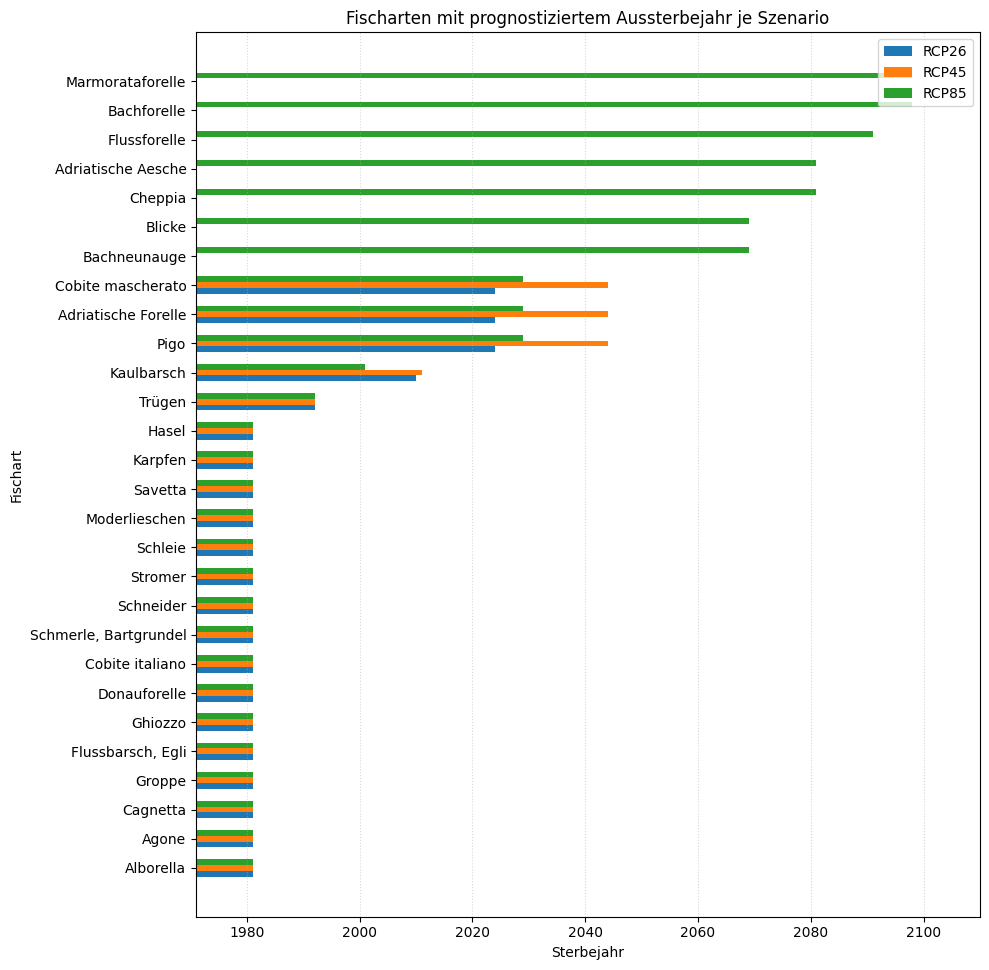

In [34]:
df_plot = fische_mit_sterbejahr.copy()
df_plot = df_plot.sort_values('Frühstes Sterbejahr', ascending=True)

fische = df_plot['Fisch']
y_pos = np.arange(len(fische))
bar_height = 0.2

# Minimum aller Sterbejahre finden (ohne Nullen)
sterbejahre = pd.concat([df_plot['RCP26'], df_plot['RCP45'], df_plot['RCP85']])
sterbejahre = sterbejahre[sterbejahre > 0]
min_jahr = sterbejahre.min()
x_start = int(min_jahr) - 10

plt.figure(figsize=(10, max(6, len(df_plot) * 0.35)))

plt.barh(y_pos - bar_height, df_plot['RCP26'], height=bar_height, color='#1f77b4', label='RCP26')
plt.barh(y_pos, df_plot['RCP45'], height=bar_height, color='#ff7f0e', label='RCP45')
plt.barh(y_pos + bar_height, df_plot['RCP85'], height=bar_height, color='#2ca02c', label='RCP85')

plt.yticks(y_pos, fische)
plt.xlabel("Sterbejahr")
plt.ylabel("Fischart")
plt.title("Fischarten mit prognostiziertem Aussterbejahr je Szenario")
plt.legend(title="Szenario")
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.xlim(x_start, 2110)  # x-Achse startet 10 Jahre vor dem frühesten Sterbejahr
plt.tight_layout()
plt.legend(loc='upper right')
plt.show()


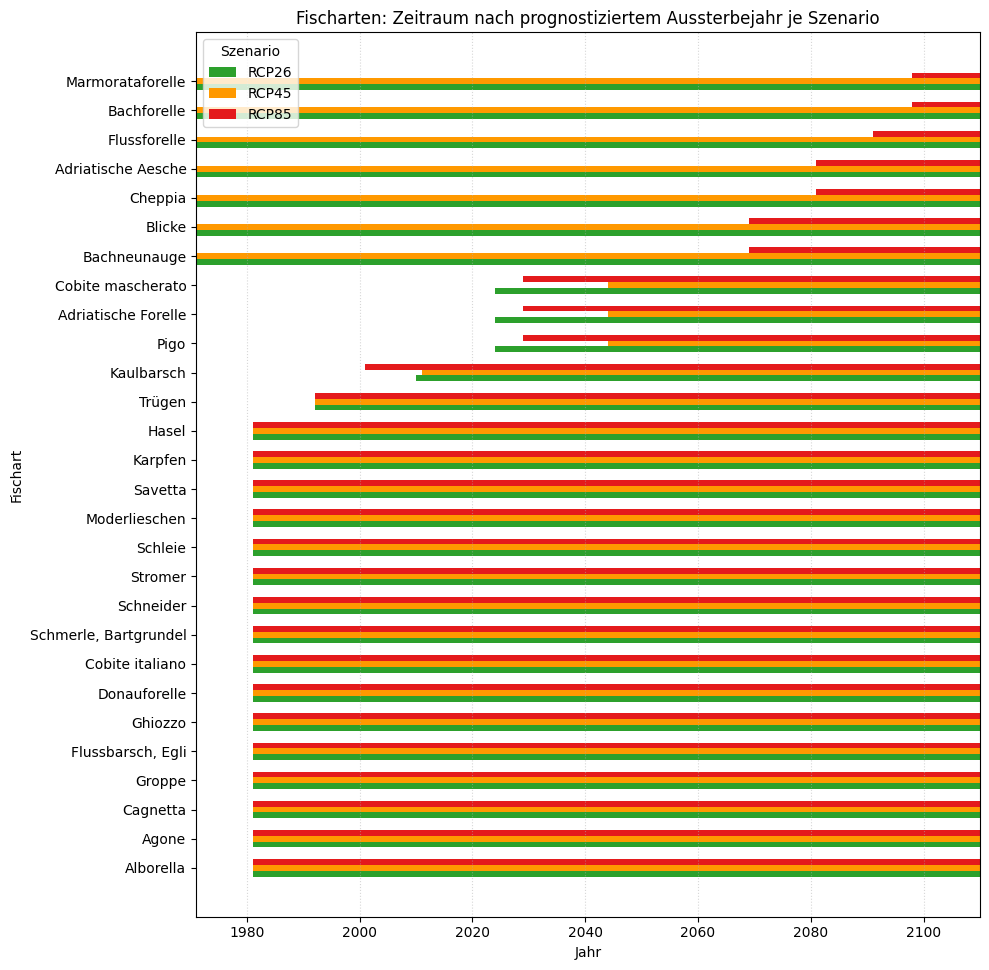

In [35]:
df_plot = fische_mit_sterbejahr.copy()
df_plot = df_plot.sort_values('Frühstes Sterbejahr', ascending=True)

fische = df_plot['Fisch']
y_pos = np.arange(len(fische))
bar_height = 0.2
szenarien = ['RCP26', 'RCP45', 'RCP85']


plt.figure(figsize=(10, max(6, len(df_plot) * 0.35)))

for i, szenario in enumerate(szenarien):
    jahre = df_plot[szenario]
    # Balken nur zeichnen, wenn Sterbejahr > 0
    left = jahre
    width = 2110 - jahre
    plt.barh(
        y_pos + (i - 1) * bar_height,  # versetzt die Balken nebeneinander
        width,
        left=left,
        height=bar_height,
        color=farben[szenario],
        label=szenario
    )

plt.yticks(y_pos, fische)
plt.xlabel("Jahr")
plt.ylabel("Fischart")
plt.title("Fischarten: Zeitraum nach prognostiziertem Aussterbejahr je Szenario")
plt.legend(title="Szenario")
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.xlim(left=min(df_plot[szenarien].replace(0, np.nan).min()) - 10, right=2110)
plt.tight_layout()
plt.show()


In [36]:
print('Aussterbejahr für Adriatische Forelle in Seen:')


fisch_name = "Adriatische Forelle"
vz.seen_mit_sterbejahr_single(df_merged, fisch_name, labels)


Aussterbejahr für Adriatische Forelle in Seen:


lake  Optimistisches Szenario  Mittleres Szenario  \
0   Oberer Luganersee                     2024                2044   
1  Unterer Luganersee                        0                2062   
2       Lago Maggiore                        0                   0   

   Pessimistisches Szenario  
0                      2029  
1                      2057  
2                      2080

C:\Users\Sandra\AppData\Local\Temp\ipykernel_18732\3126126190.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Szenario")
C:\Users\Sandra\AppData\Local\Temp\ipykernel_18732\3126126190.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper right')


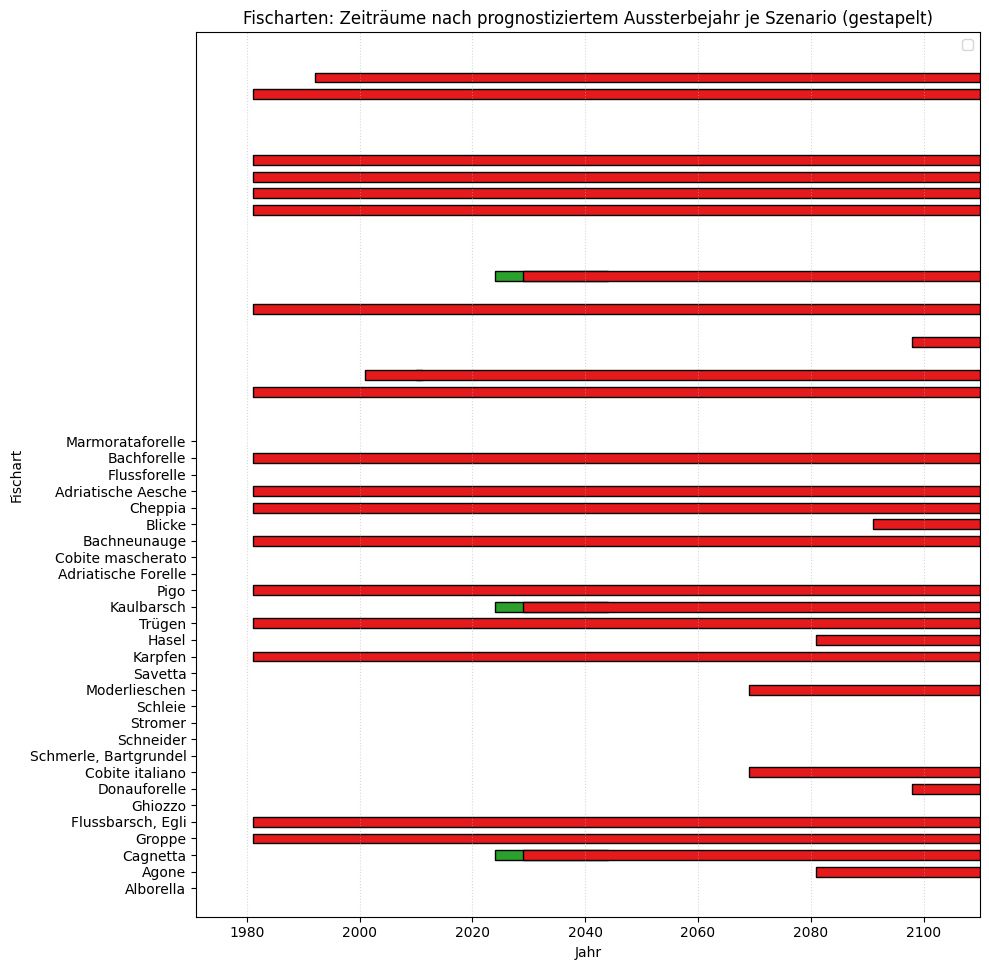

In [37]:
df_plot = fische_mit_sterbejahr.copy()
df_plot = df_plot.sort_values('Frühstes Sterbejahr', ascending=True)

fische = df_plot['Fisch']
y_pos = np.arange(len(fische))


szenarien = ['RCP26', 'RCP45', 'RCP85']

plt.figure(figsize=(10, max(6, len(df_plot) * 0.35)))

for i, row in df_plot.iterrows():
    left = row['RCP26'] if row['RCP26'] > 0 else np.nan
    width1 = (row['RCP45'] - row['RCP26']) if (row['RCP26'] > 0 and row['RCP45'] > row['RCP26']) else 0
    width2 = (row['RCP85'] - row['RCP45']) if (row['RCP45'] > 0 and row['RCP85'] > row['RCP45']) else 0
    width3 = (2110 - row['RCP85']) if (row['RCP85'] > 0 and 2110 > row['RCP85']) else 0

    # RCP26-Abschnitt
    if row['RCP26'] > 0 and width1 > 0:
        plt.barh(i, width1, left=left, color=farben['RCP26'], edgecolor='black', height=0.6, label='RCP26' if i==0 else "")
    # RCP45-Abschnitt
    if row['RCP45'] > 0 and width2 > 0:
        plt.barh(i, width2, left=row['RCP45'], color=farben['RCP45'], edgecolor='black', height=0.6, label='RCP45' if i==0 else "")
    # RCP85-Abschnitt
    if row['RCP85'] > 0 and width3 > 0:
        plt.barh(i, width3, left=row['RCP85'], color=farben['RCP85'], edgecolor='black', height=0.6, label='RCP85' if i==0 else "")

plt.yticks(y_pos, fische)
plt.xlabel("Jahr")
plt.ylabel("Fischart")
plt.title("Fischarten: Zeiträume nach prognostiziertem Aussterbejahr je Szenario (gestapelt)")
plt.xlim(left=min(df_plot[szenarien].replace(0, np.nan).min()) - 10, right=2110)
plt.legend(title="Szenario")
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


In [38]:
fisch_name = ["Adriatische Forelle"]
vz.seen_mit_sterbejahr(df_merged, fisch_name)

Fisch                lake  Aussterbejahr bei RCP26  \
0  Adriatische Forelle       Lago Maggiore                        0   
1  Adriatische Forelle  Unterer Luganersee                        0   
2  Adriatische Forelle   Oberer Luganersee                     2024   

   Aussterbejahr bei RCP45  Aussterbejahr bei RCP85  
0                        0                     2080  
1                     2062                     2057  
2                     2044                     2029

In [39]:
print('Aussterbejahr für Adriatische Forelle in Seen:')


fisch_name = "Adriatische Forelle"
vz.seen_mit_sterbejahr_single(df_merged, fisch_name, labels)


Aussterbejahr für Adriatische Forelle in Seen:


lake  Optimistisches Szenario  Mittleres Szenario  \
0   Oberer Luganersee                     2024                2044   
1  Unterer Luganersee                        0                2062   
2       Lago Maggiore                        0                   0   

   Pessimistisches Szenario  
0                      2029  
1                      2057  
2                      2080

# Fischsterben nach Szenario

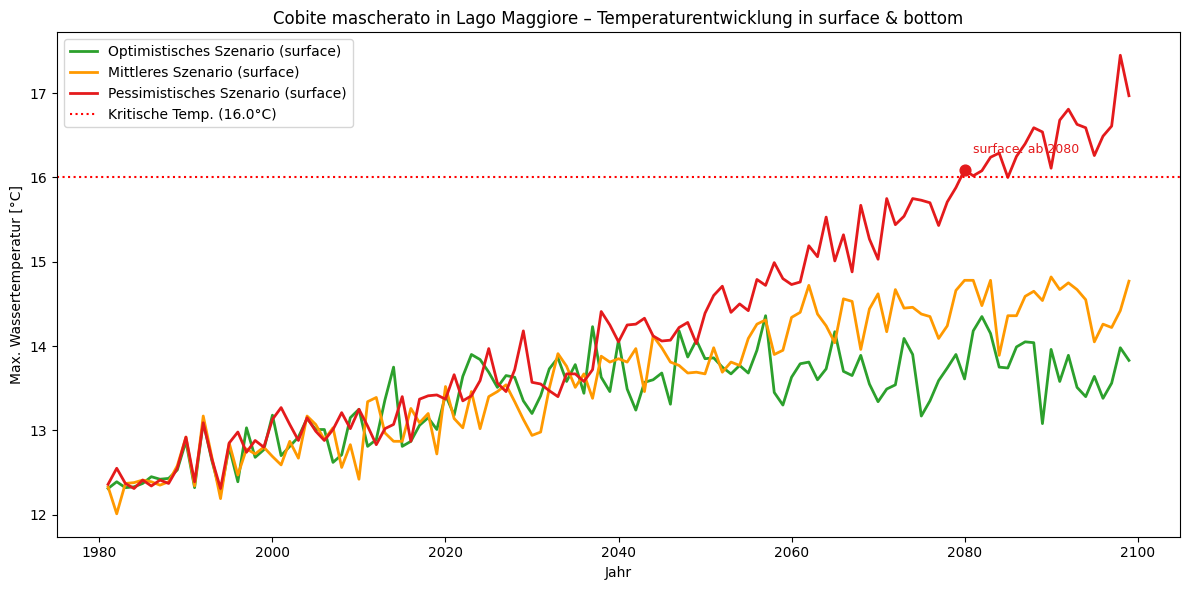

In [40]:
# Fisch mit gültiger kritischer Temperatur & überlebt = False
fisch = df_merged[(~df_merged['überlebt']) & 
                (df_merged['Kritische Temperatur °C'].notna())]['Fisch'].unique()[0]

# See dazu ermitteln
see = df_merged[(df_merged['Fisch'] == fisch) & 
                (~df_merged['überlebt'])]['lake'].unique()[0]

# Filter: Fisch + See, beide Tiefen
df_plot = df_merged[
    (df_merged['Fisch'] == fisch) &
    (df_merged['lake'] == see) &
    (df_merged["depth"] == "surface")
]

# Gruppieren: nach Jahr, Szenario, Tiefe
df_plot_grouped = df_plot.groupby(["year", "scenario", "depth"]).agg({
    "temperature_max": "mean",
    "Kritische Temperatur °C": "first"
}).reset_index()


# Plot vorbereiten
plt.figure(figsize=(12, 6))

# Linienplot für jede Tiefe + Szenario
for (scenario, depth), group in df_plot_grouped.groupby(["scenario", "depth"]):
    group_sorted = group.sort_values("year")
    linestyle = "-" if depth == "surface" else "--"
    label = f"{labels.get(scenario, scenario)} ({depth})"
    
    # Linie zeichnen
    plt.plot(group_sorted["year"], group_sorted["temperature_max"],
             label=label, color=farben.get(scenario), linestyle=linestyle, linewidth=2)
    
    # Sterbejahr markieren
    krit_temp = group_sorted["Kritische Temperatur °C"].iloc[0]
    dead = group_sorted[group_sorted["temperature_max"] > krit_temp]
    if not dead.empty:
        year_dead = dead["year"].iloc[0]
        temp_dead = dead["temperature_max"].iloc[0]
        plt.scatter(year_dead, temp_dead, color=farben[scenario], s=60)
        plt.text(year_dead + 1, temp_dead + 0.2, f"{depth}: ab {year_dead}", color=farben[scenario], fontsize=9)

# Horizontale Linie: Kritische Temperatur
plt.axhline(krit_temp, color="red", linestyle=":", label=f"Kritische Temp. ({krit_temp}°C)")

# Layout
plt.title(f"{fisch} in {see} – Temperaturentwicklung in surface & bottom")
plt.xlabel("Jahr")
plt.ylabel("Max. Wassertemperatur [°C]")
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

In [41]:
temp_spalte = "temperature_avg"  # oder "temperature_max"

# 1. Zufälliger Fisch aus dem gesamten DataFrame
alle_fische = df_merged['Fisch'].dropna().unique()
fisch = random.choice(alle_fische)


# 2. Zufälliger See, in dem dieser Fisch vorkommt
seen_vom_fisch = df_merged[df_merged['Fisch'] == fisch]['lake'].dropna().unique()
see = random.choice(seen_vom_fisch)


# 3. Filter für surface-Tiefe
df_plot = df_merged[
    (df_merged["Fisch"] == fisch) &
    (df_merged["lake"] == see) &
    (df_merged["depth"] == "surface") &
    (df_merged["Kritische Temperatur °C"].notna())
]


# Wenn keine Daten da sind (z. B. keine Kritische Temperatur oder Surface fehlt), überspringen
if df_plot.empty:
    print(f"Keine Daten für {fisch} in {see} – nächster Versuch.")
else:
    # Gruppieren
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        temp_spalte: "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()

    df_temp_avg = df_plot_grouped.groupby("year")[temp_spalte].mean().reset_index()

    krit_temp = df_plot_grouped["Kritische Temperatur °C"].iloc[0]


    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df_temp_avg["year"], df_temp_avg[temp_spalte],
             color="gray", linestyle=":", label="⌀ max. Temperatur")

    for scenario, group in df_plot_grouped.groupby("scenario"):
        group_sorted = group.sort_values("year")
        plt.plot(group_sorted["year"], group_sorted[temp_spalte],
                 label=labels.get(scenario, scenario),
                 color=farben.get(scenario), linewidth=2)

        # Szenarienname ans Ende
        x_end = group_sorted["year"].max()
        y_end = group_sorted[group_sorted["year"] == x_end][temp_spalte].values[0]
        plt.text(x_end + 1, y_end, labels.get(scenario, scenario), color=farben.get(scenario))

        # Optional: Aussterben markieren
        dead_years = group_sorted[group_sorted[temp_spalte] > krit_temp]
        if not dead_years.empty:
            year_dead = dead_years["year"].iloc[0]
            temp_dead = dead_years[temp_spalte].iloc[0]
            plt.scatter(year_dead, temp_dead, color=farben[scenario], s=70, zorder=5)
            plt.text(year_dead + 1, temp_dead + 0.3, f"stirbt ab {year_dead}", color=farben[scenario])

    plt.axhline(krit_temp, color="red", linestyle="--", label=f"Kritische Temp. ({krit_temp}°C)")
    plt.title(f"{fisch} in {see} – Temperaturentwicklung nach Szenario")
    plt.xlabel("Jahr")
    plt.ylabel("Max. Wassertemperatur [°C]")
    plt.legend()
    plt.grid(False)
    plt.xlim(right=df_plot_grouped["year"].max() + 10)
    plt.tight_layout()
    plt.show()

Keine Daten für Moderlieschen in Pfäffikersee – nächster Versuch.


interessant: adriatische forelle in upper-lugano

Frage 1: wie gehe ich mit den missing temperatur werten um ?
Frage 2: temperatur max oder temperatur avg
Frage 3: depth or surface? : 
„In dieser Analyse gehen wir davon aus, dass alle Fischarten potenziell in beiden Tiefenzonen des Sees vorkommen – auch wenn einige biologisch bevorzugt an bestimmten Stellen leben. Ziel ist es, den Einfluss des Klimawandels in verschiedenen Seeschichten vergleichbar zu machen.“



In [42]:
# Anzahl Fischarten, die aussterben je nach Temperaturtyp
def aussterbevergleich(df, temp_col):
    df_check = df.copy()
    df_check["überlebt"] = df_check[temp_col] < df_check["Kritische Temperatur °C"]
    aussterbe_fische = df_check[~df_check["überlebt"]]["Fisch"].nunique()
    return aussterbe_fische

# Beide Temperaturarten vergleichen
anzahl_max = aussterbevergleich(df_merged, "temperature_max")
anzahl_avg = aussterbevergleich(df_merged, "temperature_avg")

# Ergebnis anzeigen
print(f"Fische sterben bei temperature_max: {anzahl_max}")
print(f"Fische sterben bei temperature_avg: {anzahl_avg}")

#macht gar keinen sinn!

Fische sterben bei temperature_max: 28
Fische sterben bei temperature_avg: 23


In [43]:
# Filter rows where fish do not survive
df_deaths = df_merged[~df_merged['überlebt']][['Fisch', 'lake', 'year', 'scenario']]

# Display the resulting DataFrame
df_deaths

Fisch           lake  year scenario
714         Cagnetta  Lago Maggiore  1981    RCP26
715         Cagnetta  Lago Maggiore  1982    RCP26
716         Cagnetta  Lago Maggiore  1983    RCP26
717         Cagnetta  Lago Maggiore  1984    RCP26
718         Cagnetta  Lago Maggiore  1985    RCP26
...              ...            ...   ...      ...
467665  Donauforelle      Silsersee  2095    RCP85
467666  Donauforelle      Silsersee  2096    RCP85
467667  Donauforelle      Silsersee  2097    RCP85
467668  Donauforelle      Silsersee  2098    RCP85
467669  Donauforelle      Silsersee  2099    RCP85

[157247 rows x 4 columns]

Szenario  Anzahl toter Fische  Sterberate
0    RCP26                   21        42.0
1    RCP45                   21        42.0
2    RCP85                   28        56.0

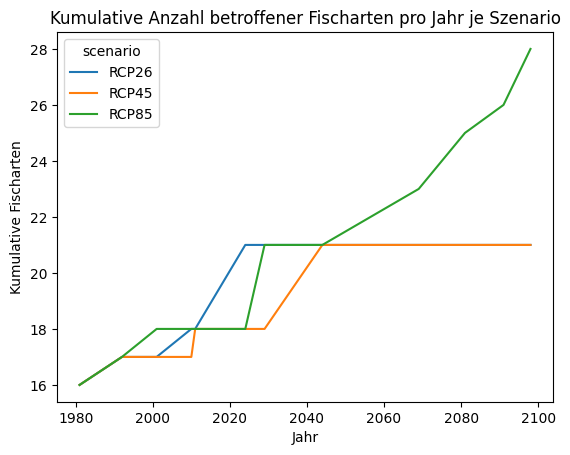

In [44]:
# Für jeden Fisch und Szenario das erste Jahr bestimmen, in dem er betroffen ist
first_death = df_deaths.groupby(['Fisch', 'scenario'])['year'].min().reset_index()

# Pro Jahr und Szenario die Zahl der erstmalig betroffenen Fische zählen
deaths_per_year_scenario = first_death.groupby(['year', 'scenario'])['Fisch'].nunique().unstack(fill_value=0)

# Kumulative Summe berechnen
deaths_cumulative_scenario = deaths_per_year_scenario.cumsum()

# Plotten
deaths_cumulative_scenario.plot(
    title="Kumulative Anzahl betroffener Fischarten pro Jahr je Szenario",
    xlabel="Jahr",
    ylabel="Kumulative Fischarten",
    grid=False
)


## Quercheck der Grafik durch Tabelle
# Anzahl der toten Fische pro Szenario berechnen
dead_fish_per_scenario = first_death.groupby('scenario')['Fisch'].nunique().reset_index()
dead_fish_per_scenario.columns = ['Szenario', 'Anzahl toter Fische']

# Gesamtanzahl der Fische berechnen
total_fish_count = df_merged['Fisch'].nunique()

# Prozentualen Anteil der toten Fische berechnen
dead_fish_per_scenario['Sterberate'] = round(((dead_fish_per_scenario['Anzahl toter Fische'] / total_fish_count) * 100), 1)

# Tabelle anzeigen
dead_fish_per_scenario

In [45]:
#Für jeden See: Welche Fischarten sind mindestens einmal vom Aussterben betroffen?

# 1. Alle Fisch-See-Kombis, bei denen überlebt == False
df_betroffen = df_merged[~df_merged["überlebt"]][["lake", "Fisch"]].drop_duplicates()

# 2. Gruppieren nach See
df_pro_see = df_betroffen.groupby("lake")["Fisch"].apply(list).reset_index()

# 3. Optional: Spalte mit Anzahl der betroffenen Arten
df_pro_see["Anzahl betroffener Fische"] = df_pro_see["Fisch"].apply(len)

# 4. Sortieren (z. B. nach Anzahl, absteigend)
df_pro_see = df_pro_see.sort_values("Anzahl betroffener Fische", ascending=False)

# Anzeigen
df_pro_see

#die umkehrung muss auch untersucht werden

lake  \
12                     Oberer Luganersee   
22                    Unterer Luganersee   
18                                Rotsee   
24                   Untersee (Bodensee)   
9                          Lago Maggiore   
13                      Oberer Zürichsee   
27         Vierwaldstättersee (Urnersee)   
23                     Unterer Zürichsee   
14                    Obersee (Bodensee)   
26    Vierwaldstättersee (Kreuztrichter)   
5                             Greifensee   
1                              Bielersee   
10                             Murtensee   
15                          Oeschinensee   
25  Vierwaldstättersee (Gersauer Becken)   
11                        Neuenburgersee   
6                           Klöntalersee   
0                           Alpnachersee   
2                            Brienzersee   
3                             Davosersee   
4                              Genfersee   
28                              Walensee   
16                          Pfäffikersee   
8                       Lac de l'Hongrin   
7                            Lac de Joux   
19                             Silsersee   
17                          Poschiavosee   
20                        Silvaplanersee   
21                       St. Moritzersee   

                                                Fisch  \
12  [Cagnetta, Agone, Cheppia, Cobite italiano, Co...   
22  [Cagnetta, Agone, Cheppia, Cobite italiano, Co...   
18  [Cheppia, Groppe, Schneider, Blicke, Karpfen, ...   
24  [Cheppia, Groppe, Schneider, Blicke, Karpfen, ...   
9   [Cagnetta, Agone, Cobite italiano, Cobite masc...   
13  [Groppe, Schneider, Blicke, Karpfen, Moderlies...   
27  [Cheppia, Groppe, Schneider, Blicke, Karpfen, ...   
23  [Cheppia, Groppe, Schneider, Blicke, Karpfen, ...   
14  [Groppe, Schneider, Blicke, Karpfen, Moderlies...   
26  [Groppe, Schneider, Blicke, Karpfen, Moderlies...   
5   [Groppe, Schneider, Blicke, Karpfen, Moderlies...   
1   [Groppe, Schneider, Blicke, Karpfen, Moderlies...   
10  [Cheppia, Groppe, Schneider, Karpfen, Hasel, S...   
15  [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
25  [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
11  [Cheppia, Groppe, Schneider, Karpfen, Hasel, S...   
6   [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
0   [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
2   [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
3   [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
4   [Cheppia, Groppe, Schneider, Karpfen, Hasel, S...   
28  [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
16  [Groppe, Schneider, Karpfen, Moderlieschen, Ha...   
8   [Groppe, Schneider, Karpfen, Hasel, Stromer, S...   
7   [Groppe, Schneider, Karpfen, Hasel, Stromer, S...   
19  [Groppe, Schleie, Schmerle, Bartgrundel, Fluss...   
17  [Groppe, Schleie, Schmerle, Bartgrundel, Donau...   
20  [Groppe, Schleie, Schmerle, Bartgrundel, Donau...   
21  [Groppe, Schleie, Schmerle, Bartgrundel, Donau...   

    Anzahl betroffener Fische  
12                         16  
22                         15  
18                         14  
24                         14  
9                          13  
13                         13  
27                         13  
23                         13  
14                         12  
26                         12  
5                          12  
1                          12  
10                         11  
15                         10  
25                         10  
11                         10  
6                          10  
0                          10  
2                          10  
3                          10  
4                          10  
28                         10  
16                         10  
8                           9  
7                           7  
19                          5  
17                          4  
20                          4  
21                          4

In [46]:
# Alle Fälle, wo ein Fisch nicht überlebt
df_betroffen = df_merged[~df_merged["überlebt"]][["Fisch", "lake"]].drop_duplicates()

# Gruppieren: Anzahl betroffener Seen pro Fisch
df_fisch_stats = df_betroffen.groupby("Fisch")["lake"].nunique().reset_index()
df_fisch_stats.columns = ["Fisch", "Anzahl betroffener Seen"]

# Sortieren (meistbetroffen oben)
df_fisch_stats = df_fisch_stats.sort_values("Anzahl betroffener Seen", ascending=False)

# Anzeigen
df_fisch_stats

Fisch  Anzahl betroffener Seen
23                Schleie                       29
15                 Groppe                       29
24  Schmerle, Bartgrundel                       26
17                Karpfen                       25
27                 Trügen                       24
26                Stromer                       22
25              Schneider                       22
16                  Hasel                       22
18             Kaulbarsch                       21
20          Moderlieschen                       17
6                  Blicke                        9
8                 Cheppia                        9
5            Bachneunauge                        9
11           Donauforelle                        4
4             Bachforelle                        3
9         Cobite italiano                        3
1     Adriatische Forelle                        3
2                   Agone                        3
3               Alborella                        3
7                Cagnetta                        3
21                   Pigo                        3
10      Cobite mascherato                        3
22                Savetta                        3
14                Ghiozzo                        3
0      Adriatische Aesche                        2
19       Marmorataforelle                        1
13           Flussforelle                        1
12      Flussbarsch, Egli                        1

In [47]:
#Wie viele verschiedene Fischarten sterben pro Szenario mindestens in einem See aus?

# 1. Alle Fälle, wo Fische nicht überleben
df_betroffen = df_merged[~df_merged["überlebt"]]

# 2. Für jedes Szenario: Anzahl einzigartiger Fischarten
df_szenario_summary = df_betroffen.groupby("scenario")["Fisch"].nunique().reset_index()
df_szenario_summary.columns = ["Szenario", "Anzahl betroffener Fischarten"]

# 3. Sortieren nach Szenario (optional)
df_szenario_summary = df_szenario_summary.sort_values("Szenario")

# Anzeigen
display(df_szenario_summary)

Szenario  Anzahl betroffener Fischarten
0    RCP26                             21
1    RCP45                             21
2    RCP85                             28

In [48]:
# 1. Alle Kombinationen, in denen der Fisch nicht überlebt
df_betroffen = df_merged[~df_merged["überlebt"]]

# 2. Gruppieren: Für jedes Szenario & jeden See → Anzahl betroffener Fischarten
df_szenario_see = df_betroffen.groupby(["scenario", "lake"])["Fisch"].nunique().reset_index()
df_szenario_see.columns = ["Szenario", "See", "Anzahl betroffener Fischarten"]

# 3. Sortieren (optional)
df_szenario_see = df_szenario_see.sort_values(["Szenario", "Anzahl betroffener Fischarten"], ascending=[True, False])

# 4. Anzeigen
display(df_szenario_see)

Szenario                 See  Anzahl betroffener Fischarten
12    RCP26   Oberer Luganersee                             13
5     RCP26          Greifensee                             10
13    RCP26    Oberer Zürichsee                             10
18    RCP26              Rotsee                             10
22    RCP26  Unterer Luganersee                             10
..      ...                 ...                            ...
65    RCP85         Lac de Joux                              7
77    RCP85           Silsersee                              5
75    RCP85        Poschiavosee                              4
78    RCP85      Silvaplanersee                              4
79    RCP85     St. Moritzersee                              4

[87 rows x 3 columns]

### Szenarien Plot mit Sterbejahr - geglättet und Rauschen

In [49]:
fisch = "Adriatische Forelle"

df_forelle = df_merged[
    (df_merged["Fisch"] == fisch) &
    (df_merged["depth"].str.strip().str.lower() == "surface")
].copy()

seen_forelle = df_forelle["lake"].unique()
print("Seen:", seen_forelle)

df_forelle

Seen: ['Lago Maggiore' 'Unterer Luganersee' 'Oberer Luganersee']


Fisch Name wissenschaftlich Einzugsgebiet  \
13566  Adriatische Forelle       Salmo cenerinus        Ticino   
13567  Adriatische Forelle       Salmo cenerinus        Ticino   
13568  Adriatische Forelle       Salmo cenerinus        Ticino   
13569  Adriatische Forelle       Salmo cenerinus        Ticino   
13570  Adriatische Forelle       Salmo cenerinus        Ticino   
...                    ...                   ...           ...   
48190  Adriatische Forelle       Salmo cenerinus        Ticino   
48191  Adriatische Forelle       Salmo cenerinus        Ticino   
48192  Adriatische Forelle       Salmo cenerinus        Ticino   
48193  Adriatische Forelle       Salmo cenerinus        Ticino   
48194  Adriatische Forelle       Salmo cenerinus        Ticino   

      Gefährdungsstatus  Kritische Temperatur °C Minimale Temperatur °C  \
13566                 1                     16.0                      7   
13567                 1                     16.0                      7   
13568                 1                     16.0                      7   
13569                 1                     16.0                      7   
13570                 1                     16.0                      7   
...                 ...                      ...                    ...   
48190                 1                     16.0                      7   
48191                 1                     16.0                      7   
48192                 1                     16.0                      7   
48193                 1                     16.0                      7   
48194                 1                     16.0                      7   

       Kritischer O2-Grenzwert (mg/l)               lake  year  \
13566                             3.0      Lago Maggiore  1981   
13567                             3.0      Lago Maggiore  1982   
13568                             3.0      Lago Maggiore  1983   
13569                             3.0      Lago Maggiore  1984   
13570                             3.0      Lago Maggiore  1985   
...                               ...                ...   ...   
48190                             3.0  Oberer Luganersee  2095   
48191                             3.0  Oberer Luganersee  2096   
48192                             3.0  Oberer Luganersee  2097   
48193                             3.0  Oberer Luganersee  2098   
48194                             3.0  Oberer Luganersee  2099   

       temperature_avg  temperature_min  temperature_max scenario    depth  \
13566            11.73            11.20            12.31    RCP26  surface   
13567            11.87            11.56            12.39    RCP26  surface   
13568            11.92            11.68            12.32    RCP26  surface   
13569            11.51            10.75            12.33    RCP26  surface   
13570            11.97            11.53            12.37    RCP26  surface   
...                ...              ...              ...      ...      ...   
48190            17.40            16.46            18.20    RCP85  surface   
48191            17.27            16.35            18.57    RCP85  surface   
48192            17.69            16.37            18.48    RCP85  surface   
48193            17.32            16.33            19.50    RCP85  surface   
48194            17.64            16.38            18.97    RCP85  surface   

       überlebt  
13566      True  
13567      True  
13568      True  
13569      True  
13570      True  
...         ...  
48190     False  
48191     False  
48192     False  
48193     False  
48194     False  

[1071 rows x 15 columns]

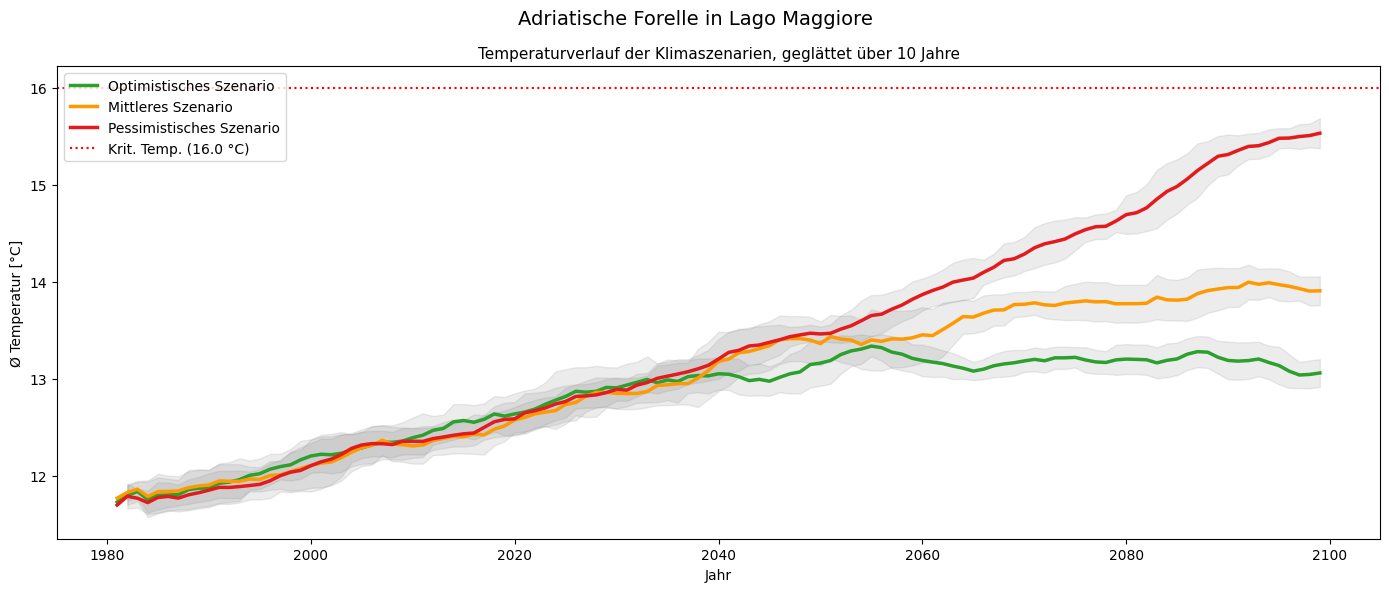

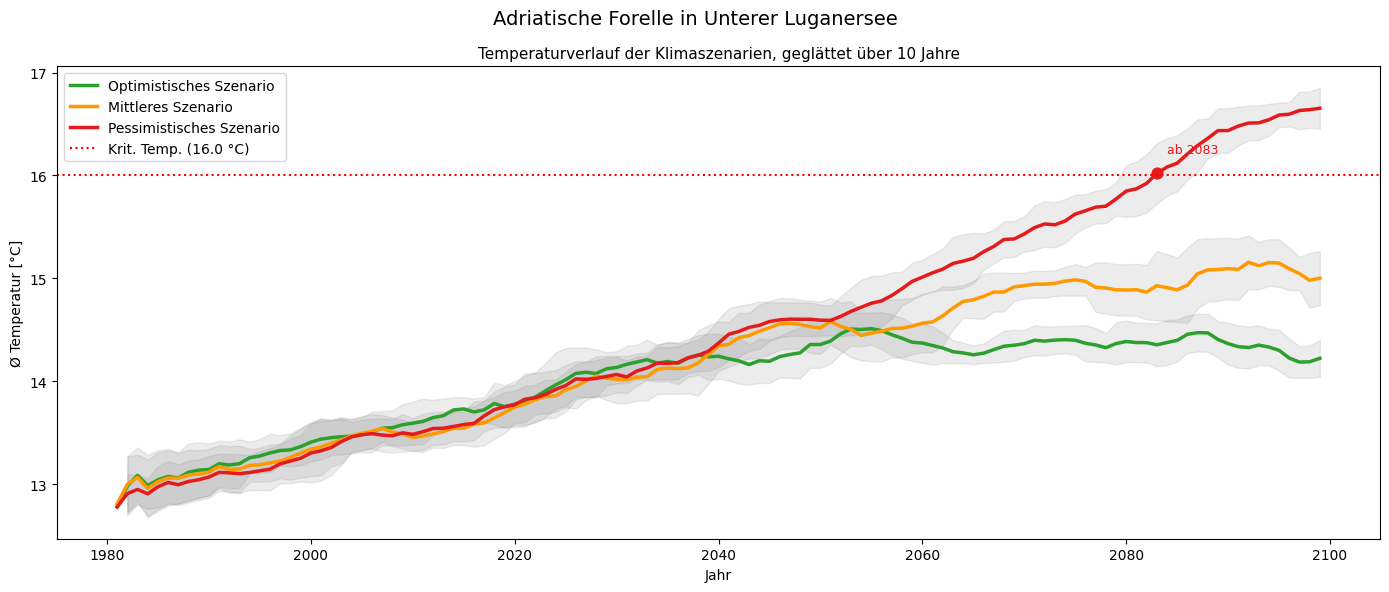

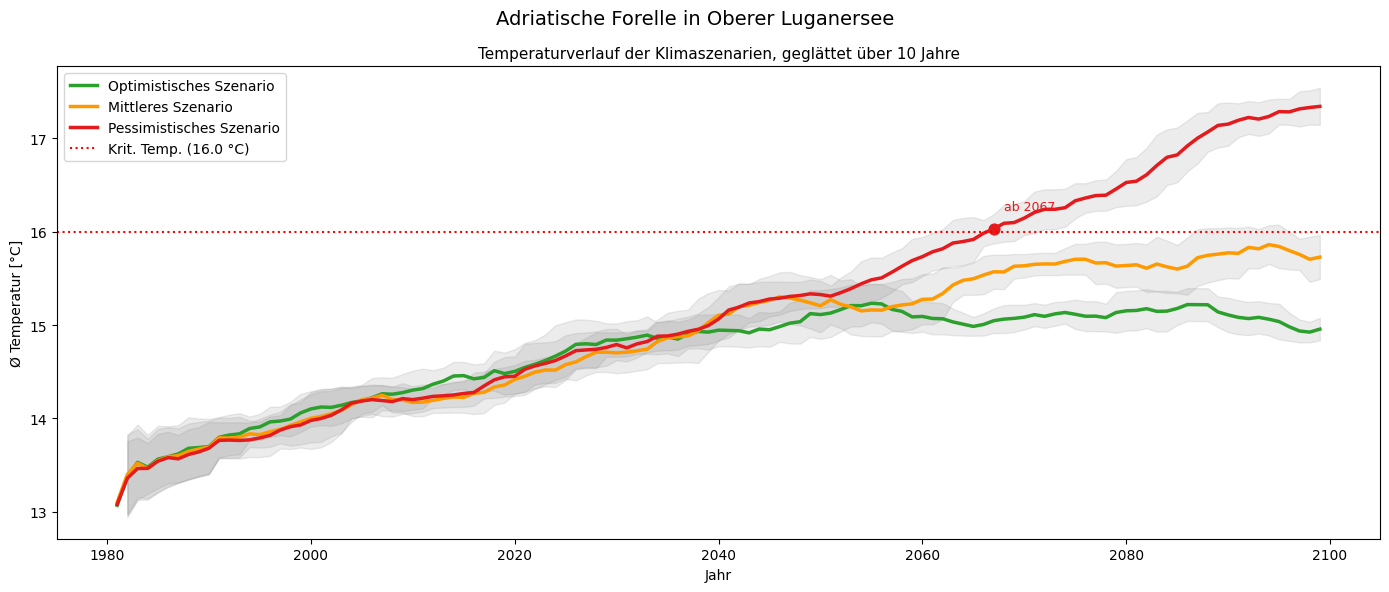

In [ ]:
window = 10  # Rolling-Window in Jahren

for see in seen_forelle:
    df_plot = df_forelle[df_forelle["lake"] == see]
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        "temperature_avg": "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()

    plt.figure(figsize=(14, 6))

    for scenario in df_plot_grouped["scenario"].unique():
        gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")

        # Rolling-Werte
        rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean()
        rolling_std = gruppe["temperature_avg"].rolling(window=window, min_periods=1).std()

        years = gruppe["year"]
        farbe = farben.get(scenario, "gray")

        # Hauptlinie
        plt.plot(years, rolling_avg,
                 label=labels.get(scenario, scenario),
                 color=farbe, linewidth=2.5)

        # Unsicherheitsband (grau mit Farbkante)
        plt.fill_between(years,
                         rolling_avg - rolling_std,
                         rolling_avg + rolling_std,
                         color="gray", alpha=0.15)

        # Kritischer Punkt
        krit_temp = gruppe["Kritische Temperatur °C"].iloc[0]
        dead = gruppe[rolling_avg > krit_temp]
        if not dead.empty:
            year_dead = dead["year"].iloc[0]
            temp_dead = rolling_avg[dead.index[0]]
            plt.scatter(year_dead, temp_dead, color=farbe, s=60)
            plt.text(year_dead + 1, temp_dead + 0.2,
                     f"ab {year_dead}", color=farbe, fontsize=9)

    # Kritische Temperaturlinie
    plt.axhline(krit_temp, color="red", linestyle=":", linewidth=1.5,
                label=f"Krit. Temp. ({krit_temp:.1f} °C)")

    plt.suptitle(f"{fisch} in {see}", fontsize=14)
    plt.title("Temperaturverlauf der Klimaszenarien, geglättet über 10 Jahre", fontsize=11)
    plt.xlabel("Jahr")
    plt.ylabel("Ø Temperatur [°C]")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()




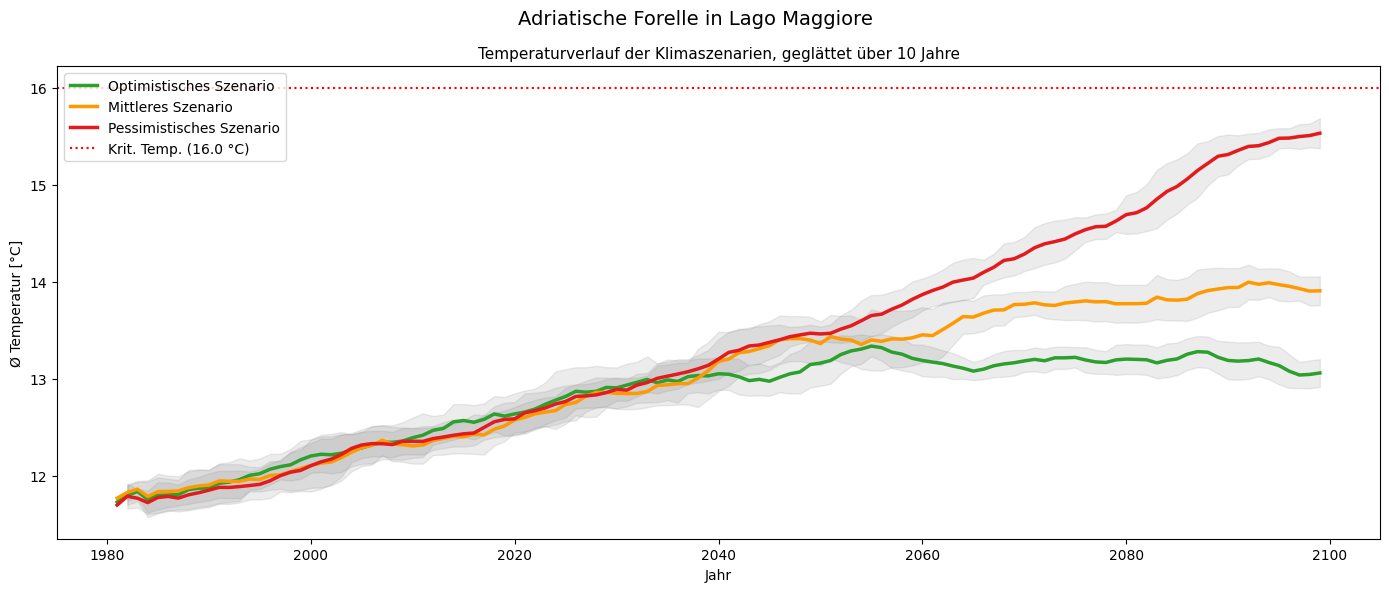

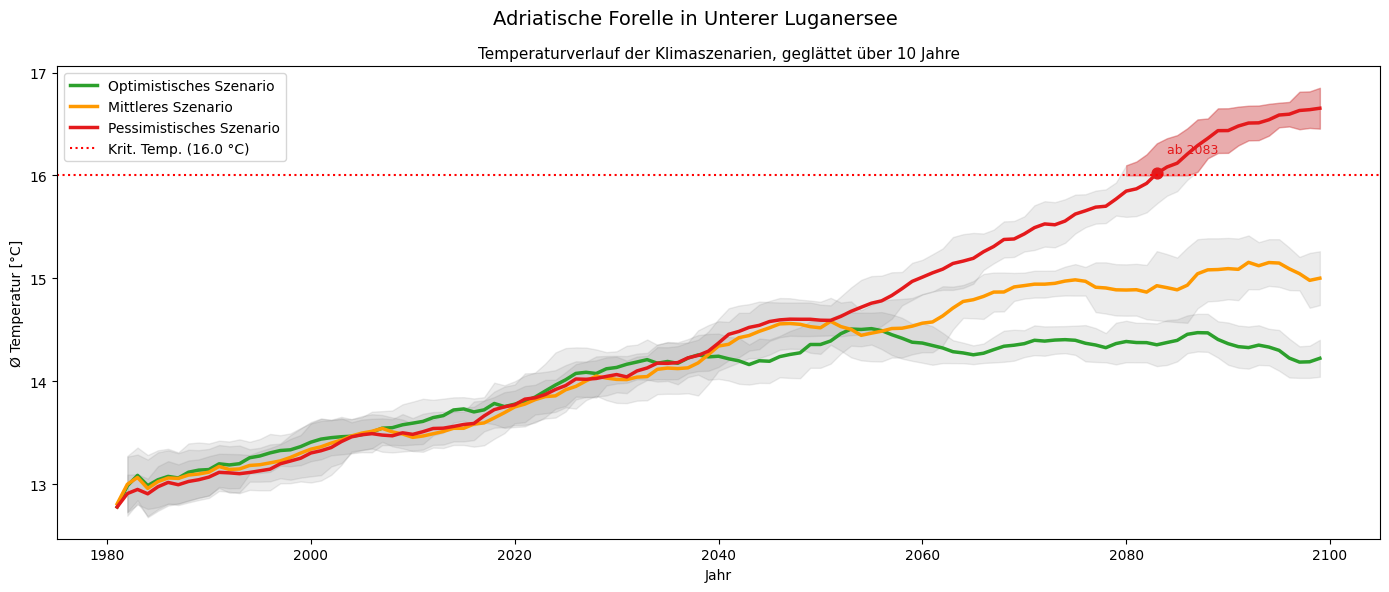

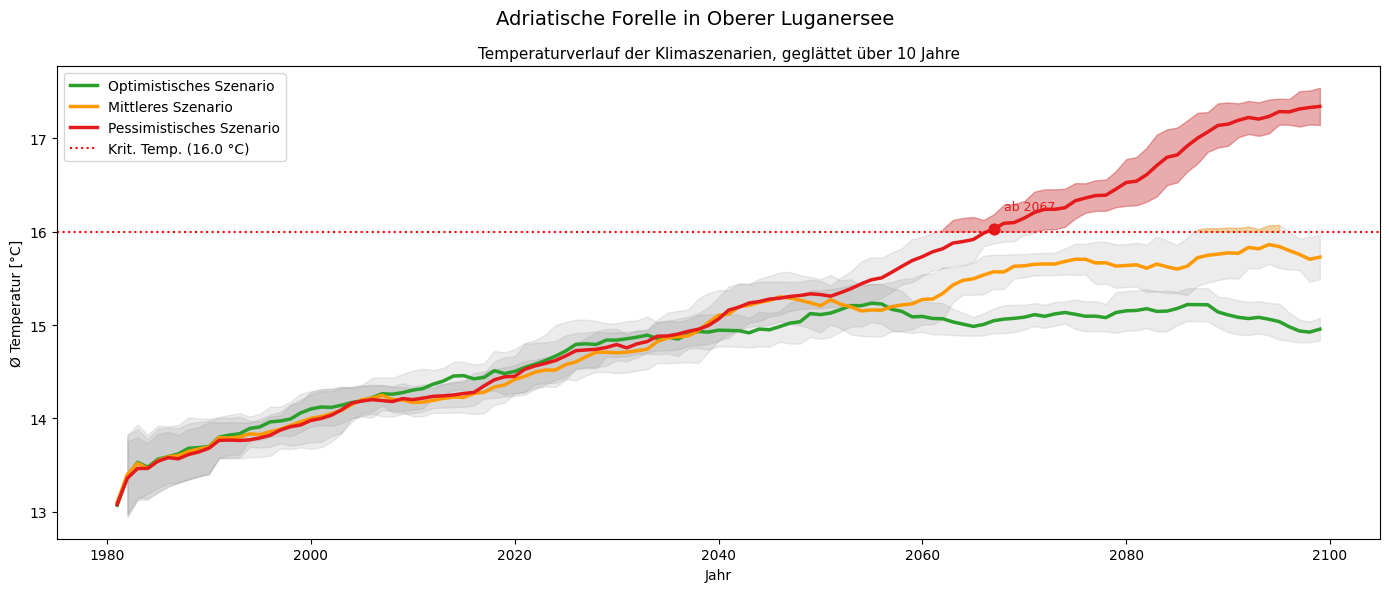

In [51]:
window = 10

for see in seen_forelle:
    df_plot = df_forelle[df_forelle["lake"] == see]
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        "temperature_avg": "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()

    plt.figure(figsize=(14, 6))

    for scenario in df_plot_grouped["scenario"].unique():
        gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
        years = gruppe["year"].to_numpy()
        krit_temp = gruppe["Kritische Temperatur °C"].iloc[0]
        farbe = farben.get(scenario, "gray")

        rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean().to_numpy()
        rolling_std = gruppe["temperature_avg"].rolling(window=window, min_periods=1).std().to_numpy()
        upper = rolling_avg + rolling_std
        lower = rolling_avg - rolling_std

        # 1. Grauer Grundbereich ohne Lücken
        plt.fill_between(years, lower, upper, color="gray", alpha=0.15)

        # 2. Farbiger Bereich oberhalb der kritischen Temperatur
        mask = upper > krit_temp
        plt.fill_between(years,
                         np.where(mask, np.maximum(lower, krit_temp), np.nan),
                         np.where(mask, upper, np.nan),
                         color=farbe, alpha=0.3)

        # Hauptlinie
        plt.plot(years, rolling_avg, label=labels.get(scenario, scenario), color=farbe, linewidth=2.5)

        # Kritischer Punkt
        exceed_index = np.argmax(rolling_avg > krit_temp)
        if rolling_avg[exceed_index] > krit_temp:
            year_dead = years[exceed_index]
            temp_dead = rolling_avg[exceed_index]
            plt.scatter(year_dead, temp_dead, color=farbe, s=60)
            plt.text(year_dead + 1, temp_dead + 0.2, f"ab {year_dead}", color=farbe, fontsize=9)

    # Kritische Linie
    plt.axhline(krit_temp, color="red", linestyle=":", linewidth=1.5,
                label=f"Krit. Temp. ({krit_temp:.1f} °C)")

    plt.suptitle(f"{fisch} in {see}", fontsize=14)
    plt.title("Temperaturverlauf der Klimaszenarien, geglättet über 10 Jahre", fontsize=11)
    plt.xlabel("Jahr")
    plt.ylabel("Ø Temperatur [°C]")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


## Line chart to use

In [52]:
def to_rgba(color: str, alpha: float = 0.3) -> str:
    """
    Convert a color string to an RGBA string with the specified alpha value.

    Args:
        color (str): Color as 'rgb(R,G,B)', '#RRGGBB', or 'rgba(R,G,B,A)'.
        alpha (float, optional): Alpha value for transparency (0 to 1). Defaults to 0.3.

    Returns:
        str: Color as 'rgba(R,G,B,alpha)' or original string if conversion fails.
    """
    if isinstance(color, str) and color.startswith("rgb("):
        nums = re.findall(r'\d+', color)
        return f"rgba({nums[0]},{nums[1]},{nums[2]},{alpha})"
    elif isinstance(color, str) and color.startswith("#"):
        h = color.lstrip("#")
        return f"rgba({int(h[0:2],16)},{int(h[2:4],16)},{int(h[4:6],16)},{alpha})"
    elif isinstance(color, str) and color.startswith("rgba("):
        # Replace alpha value
        return re.sub(r'rgba\((\d+),(\d+),(\d+),[0-9.]+\)', 
                      fr'rgba(\1,\2,\3,{alpha})', color)
    else:
        return color

### function for Datastory

In [53]:
def plot_forelle_scenario_animated(
    df_forelle: pd.DataFrame,
    see: str,
    fisch: str,
    farben: Dict[str, str],
    labels: Dict[str, str],
    window: int = 10
) -> go.Figure:
    """
    Animates all plot elements as in the static plot, but with a "bottom-up" animation.
    The x- and y-axes are fixed to the global min/max of all lines for a stable animation.
    """
    import numpy as np
    import plotly.graph_objects as go
    import re

    def to_rgba(color: str, alpha: float = 0.3) -> str:
        """Convert color to rgba string with given alpha."""
        if isinstance(color, str) and color.startswith("rgb("):
            nums = re.findall(r'\d+', color)
            return f"rgba({nums[0]},{nums[1]},{nums[2]},{alpha})"
        elif isinstance(color, str) and color.startswith("#"):
            h = color.lstrip("#")
            return f"rgba({int(h[0:2],16)},{int(h[2:4],16)},{int(h[4:6],16)},{alpha})"
        elif isinstance(color, str) and color.startswith("rgba("):
            return re.sub(r'rgba\((\d+),(\d+),(\d+),[0-9.]+\)', 
                        fr'rgba(\1,\2,\3,{alpha})', color)
        else:
            return color

    # Filter data for the selected lake
    df_plot = df_forelle[df_forelle["lake"] == see]
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        "temperature_avg": "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()
    years_all = sorted(df_plot_grouped["year"].unique())

    # --- Calculate global x and y ranges for all traces ---
    x_min = df_plot_grouped["year"].min()
    x_max = df_plot_grouped["year"].max()

    # Compute all rolling averages and stds for all scenarios to find y-axis bounds
    y_values = []
    for scenario in df_plot_grouped["scenario"].unique():
        gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
        rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean()
        rolling_std = gruppe["temperature_avg"].rolling(window=window, min_periods=1).std()
        upper = rolling_avg + rolling_std
        lower = rolling_avg - rolling_std
        y_values.extend(upper)
        y_values.extend(lower)
    # Also include critical temperature line in y-range
    y_values.extend(df_plot_grouped["Kritische Temperatur °C"].unique())
    y_min = float(np.nanmin(y_values))
    y_max = float(np.nanmax(y_values))

    fig = go.Figure()

    fig.update_layout(
        title=dict(
            text=f"{fisch} in {see}",
            font=dict(size=18),
            x=0.5,
            xanchor='center',
            subtitle=dict(
                text="Temperature development of climate scenarios, smoothed over 10 years",
                font=dict(size=14, color="gray")
            )
        ),
        xaxis_title="Year",
        yaxis_title="Ø Temperature [°C]",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        ),
        hovermode="x unified",
        template="plotly_white",
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 60, "redraw": True}, "fromcurrent": True}]
            }]
        }],
        xaxis=dict(range=[x_min, x_max]),  # <-- Fix x-axis
        yaxis=dict(range=[y_min, y_max])   # <-- Fix y-axis
    )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)

    frames = []
    for frame_year in years_all:
        frame_data = []
        for i, scenario in enumerate(df_plot_grouped["scenario"].unique()):
            gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
            years = gruppe["year"].to_numpy()
            mask_frame = years <= frame_year
            years_visible = years[mask_frame]
            if len(years_visible) == 0:
                continue
            farbe = farben.get(scenario, "gray")
            rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean().to_numpy()[mask_frame]
            rolling_std = gruppe["temperature_avg"].rolling(window=window, min_periods=1).std().to_numpy()[mask_frame]
            upper = rolling_avg + rolling_std
            lower = rolling_avg - rolling_std
            krit_temp = gruppe["Kritische Temperatur °C"].iloc[0]

            # Gray area for noise (1 std)
            frame_data.append(go.Scatter(
                x=years_visible,
                y=upper,
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                hoverinfo='skip'
            ))
            frame_data.append(go.Scatter(
                x=years_visible,
                y=lower,
                mode='lines',
                fill='tonexty',
                fillcolor='rgba(128,128,128,0.15)',
                line=dict(width=0),
                name='Noise (1 Std)' if (i == 0 and frame_year == years_all[0]) else None,
                legendgroup='noise',
                hoverinfo='skip',
                showlegend=bool(i == 0 and frame_year == years_all[0])
            ))

            # Colored area for noise above critical temperature
            mask = upper > krit_temp
            upper_noise = np.where(mask, upper, np.nan)
            lower_noise = np.where(mask, np.maximum(lower, krit_temp), np.nan)
            frame_data.append(go.Scatter(
                x=years_visible,
                y=upper_noise,
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                hoverinfo='skip'
            ))
            frame_data.append(go.Scatter(
                x=years_visible,
                y=lower_noise,
                mode='lines',
                fill='tonexty',
                fillcolor=to_rgba(farbe, 0.3),
                line=dict(width=0),
                name=None,
                showlegend=False,
                hoverinfo='skip'
            ))

            # Main animated line
            frame_data.append(go.Scatter(
                x=years_visible,
                y=rolling_avg,
                mode='lines',
                name=labels.get(scenario, scenario),
                line=dict(color=farbe, width=2.5),
                legendgroup=scenario,
                showlegend=bool(frame_year == years_all[0])
            ))

            # Exceedance year marker (if visible in this frame)
            exceed = np.where(rolling_avg > krit_temp)[0]
            if len(exceed) > 0:
                exceed_index = exceed[0]
                year_dead = years_visible[exceed_index]
                temp_dead = rolling_avg[exceed_index]
                frame_data.append(go.Scatter(
                    x=[year_dead],
                    y=[temp_dead],
                    mode='markers+text',
                    marker=dict(color=farbe, size=10),
                    text=[f"from {year_dead}"],
                    textposition="top right",
                    showlegend=False,
                    hoverinfo='text',
                    textfont=dict(
                        color="black",
                        size=12,
                        family="Arial Black"
                    )
                ))

        # Critical temperature line
        frame_data.append(go.Scatter(
            x=years_all,
            y=[krit_temp]*len(years_all),
            mode='lines',
            line=dict(color='red', dash='dot', width=1.5),
            name=f"Critical temp. ({krit_temp:.1f} °C)",
            legendgroup='krit',
            showlegend=bool(frame_year == years_all[0])
        ))
        frames.append(go.Frame(data=frame_data, name=str(frame_year)))

    fig.add_traces(frames[0].data)
    fig.frames = frames
    return fig


In [54]:
plot_forelle_scenario_animated(df_forelle, see="Oberer Luganersee", fisch="Adriatische Forelle", farben=farben, labels=labels, window=10)


In [55]:
def plot_forelle_scenario_animated(
    df_forelle: pd.DataFrame,
    see: str,
    fisch: str,
    window: int = 10
) -> go.Figure:
    # Farben und Labels für Szenarien
    farben = {"RCP26": "#2ca02c", "RCP45": "#ff9900", "RCP85": "#e41a1c"}
    labels = {"RCP26": "Optimistisches Szenario", "RCP45": "Mittleres Szenario", "RCP85": "Pessimistisches Szenario"}

    df_plot = df_forelle[df_forelle["lake"] == see]
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        "temperature_avg": "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()
    
    years_all = sorted(df_plot_grouped["year"].unique())
    krit_temp = df_plot_grouped["Kritische Temperatur °C"].iloc[0]
    scenarios = df_plot_grouped["scenario"].unique()
    
    fig = go.Figure()

    # Kritische Temperatur-Linie (immer sichtbar, nicht animiert)
    fig.add_trace(go.Scatter(
        x=years_all,
        y=[krit_temp] * len(years_all),
        mode='lines',
        line=dict(color='red', dash='dot', width=1.5),
        name=f"Krit. Temp. ({krit_temp:.1f} °C)",
        legendgroup='krit',
        showlegend=True
    ))
    
    frames = []
    for frame_year in years_all:
        frame_data = []
        for i, scenario in enumerate(scenarios):
            gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
            years = gruppe["year"].to_numpy()
            mask_frame = years <= frame_year
            years_visible = years[mask_frame]
            if len(years_visible) == 0:
                continue
            farbe = farben.get(scenario, "gray")
            rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean().to_numpy()[mask_frame]
            rolling_std = gruppe["temperature_avg"].rolling(window=window, min_periods=1).std().to_numpy()[mask_frame]
            upper = rolling_avg + rolling_std
            lower = rolling_avg - rolling_std

            # Grauer Bereich für Noise (1 Std) - immer
            frame_data.append(go.Scatter(
                x=years_visible,
                y=upper,
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                hoverinfo='skip'
            ))
            frame_data.append(go.Scatter(
                x=years_visible,
                y=lower,
                mode='lines',
                fill='tonexty',
                fillcolor='rgba(128,128,128,0.15)',
                line=dict(width=0),
                name='Noise (1 Std)' if (i == 0 and frame_year == years_all[0]) else None,
                legendgroup='noise',
                hoverinfo='skip',
                showlegend=bool(i == 0 and frame_year == years_all[0])
            ))

            # Noise (nur über kritischem Wert, in Linienfarbe mit Alpha 0.3)
            mask = upper > krit_temp
            if any(mask):
                upper_noise = np.where(mask, upper, np.nan)
                lower_noise = np.where(mask, np.maximum(lower, krit_temp), np.nan)
                frame_data.append(go.Scatter(
                    x=years_visible,
                    y=upper_noise,
                    mode='lines',
                    line=dict(width=0),
                    showlegend=False,
                    hoverinfo='skip'
                ))
                frame_data.append(go.Scatter(
                    x=years_visible,
                    y=lower_noise,
                    mode='lines',
                    fill='tonexty',
                    fillcolor=to_rgba(farbe, 0.3),
                    line=dict(width=0),
                    name=None,
                    showlegend=False,
                    hoverinfo='skip'
                ))

            # Hauptlinie animiert
            frame_data.append(go.Scatter(
                x=years_visible,
                y=rolling_avg,
                mode='lines',
                name=labels.get(scenario, scenario),
                line=dict(color=farbe, width=2.5), 
                legendgroup=scenario,
                showlegend=bool(frame_year == years_all[0])
            ))

            # Exceedance year marker (mit Text "ab Jahr")
            exceed = np.where(rolling_avg > krit_temp)[0]
            if len(exceed) > 0:
                exceed_index = exceed[0]
                year_dead = years_visible[exceed_index]
                temp_dead = rolling_avg[exceed_index]
                frame_data.append(go.Scatter(
                    x=[year_dead],
                    y=[temp_dead],
                    mode='markers+text',
                    marker=dict(color=farbe, size=10),
                    text=[f"ab {year_dead}"],
                    textposition="top right",
                    showlegend=False,
                    hoverinfo='text',
                    textfont=dict(
                        color="black",
                        size=12,
                        family="Arial Black"
                    )
                ))

        frames.append(go.Frame(data=frame_data, name=str(frame_year)))

    fig.add_traces(frames[0].data)
    fig.frames = frames

    fig.update_layout(
        title=dict(
            text=f"{fisch} in {see}",
            font=dict(size=18),
            x=0.5,
            xanchor='center',
            subtitle=dict(
                text="Temperaturverlauf der Klimaszenarien, geglättet über 10 Jahre",
                font=dict(size=14, color="gray")
            )
        ),
        xaxis_title="Jahr",
        yaxis_title="Ø Temperatur [°C]",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        ),
        hovermode="x unified",
        template="plotly_white",
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {"frame": {"duration": 60, "redraw": True}, "fromcurrent": True}]
            }]
        }]
    )
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)
    return fig


In [56]:
plot_forelle_scenario_animated(df_forelle, see="Oberer Luganersee", fisch="Adriatische Forelle", window=10)


In [57]:
def plot_forelle_scenario_animated_lines(
    df_forelle: pd.DataFrame,
    see: str,
    fisch: str,
    farben: dict,
    labels: dict,
    window: int = 10
) -> 'go.Figure':
    """
    Animated line plot for scenarios, animating lines from bottom to top.
    Axes and tick labels are fixed and black.
    """
    import numpy as np
    import plotly.graph_objects as go

    # Prepare data
    df_plot = df_forelle[df_forelle["lake"] == see]
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        "temperature_avg": "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()
    years_all = sorted(df_plot_grouped["year"].unique())

    # --- Calculate global x and y ranges for all traces ---
    x_min = df_plot_grouped["year"].min()
    x_max = df_plot_grouped["year"].max()

    y_values = []
    for scenario in df_plot_grouped["scenario"].unique():
        gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
        rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean()
        y_values.extend(rolling_avg)
    y_values.extend(df_plot_grouped["Kritische Temperatur °C"].unique())
    y_min = float(np.nanmin(y_values))
    y_max = float(np.nanmax(y_values))

    fig = go.Figure()

    fig.update_layout(
        title=dict(
            text=f"{fisch} in {see}",
            font=dict(size=18, color="black"),
            x=0.5,
            xanchor='center',
            subtitle=dict(
                text="Temperaturverlauf der Klimaszenarien, geglättet über 10 Jahre",
                font=dict(size=14, color="gray")
            )
        ),
        xaxis_title="Jahr",
        yaxis_title="Ø Temperatur [°C]",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1
        ),
        hovermode="x unified",
        template="plotly_white",
        plot_bgcolor='rgba(0,0,0,0)',
        paper_bgcolor='rgba(0,0,0,0)',

        # updatemenus=[{
        #     "type": "buttons",
        #     "showactive": False,
        #     "buttons": [{
        #         "label": "Play",
        #         "method": "animate",
        #         "args": [None, {
        #             "frame": {"duration": 60, "redraw": True}, 
        #             "fromcurrent": True}]
        
        updatemenus=[{
            "type": "buttons",
            "showactive": False,
            "buttons": [{
                "label": "Play",
                "method": "animate",
                "args": [None, {
                    "frame": {"duration": 60, "redraw": True}, 
                    "fromcurrent": True}]
            

            }]
        }]
    )
    
    # Set x and y axis ranges and color/tickfont
    fig.update_xaxes(
        range=[x_min, x_max],
        color='black',                  # axis line and ticks
        tickfont=dict(color='black'),   # tick labels
        showgrid=False
    )
    fig.update_yaxes(
        range=[y_min, y_max],
        color='black',
        tickfont=dict(color='black'),
        showgrid=False
    )

    # Build frames
    frames = []
    for frame_year in years_all:
        frame_data = []
        for i, scenario in enumerate(df_plot_grouped["scenario"].unique()):
            gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
            years = gruppe["year"].to_numpy()
            mask_frame = years <= frame_year
            years_visible = years[mask_frame]
            if len(years_visible) == 0:
                continue
            farbe = farben.get(scenario, "gray")
            rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean().to_numpy()[mask_frame]
            # Animated main line
            frame_data.append(go.Scatter(
                x=years_visible,
                y=rolling_avg,
                mode='lines',
                name=labels.get(scenario, scenario),
                line=dict(color=farbe, width=2.5),
                legendgroup=scenario,
                showlegend=bool(frame_year == years_all[0])
            ))
        # Critical temperature line (fixed)
        krit_temp = gruppe["Kritische Temperatur °C"].iloc[0]
        frame_data.append(go.Scatter(
            x=years_all,
            y=[krit_temp]*len(years_all),
            mode='lines',
            line=dict(color='red', dash='dot', width=1.5),
            name=f"Krit. Temp. ({krit_temp:.1f} °C)",
            legendgroup='krit',
            showlegend=bool(frame_year == years_all[0])
        ))
        frames.append(go.Frame(data=frame_data, name=str(frame_year)))

    fig.add_traces(frames[0].data)
    fig.frames = frames

    return fig


In [58]:
plot_forelle_scenario_animated_lines(df_forelle, see="Oberer Luganersee", farben=farben, labels=labels, fisch="Adriatische Forelle",  window=10)


In [59]:
vz.plot_forelle_scenario_animated_lines(df_forelle, see="Oberer Luganersee", farben=farben, labels=labels, fisch="Adriatische Forelle",  window=10)


### functions for Dashboard

In [61]:
df_dashboard = pd.read_csv('../data/temperaturdaten_kombiniert.csv')
df_dashboard

See Szenario  Jahr  Temperatur
0          LakeDavos    RCP26  1981        8.53
1          LakeDavos    RCP26  1982        8.42
2          LakeDavos    RCP26  1983        8.55
3          LakeDavos    RCP26  1984        8.01
4          LakeDavos    RCP26  1985        8.33
...              ...      ...   ...         ...
10348  LacdelHongrin    RCP85  2095       17.15
10349  LacdelHongrin    RCP85  2096       16.77
10350  LacdelHongrin    RCP85  2097       17.32
10351  LacdelHongrin    RCP85  2098       17.89
10352  LacdelHongrin    RCP85  2099       17.90

[10353 rows x 4 columns]

In [ ]:
def plot_scenario(
    df: pd.DataFrame,
    see: str,
    fisch: str,
    window: int = 10
    ) -> go.Figure:

    """
    Plots the scenario temperature development for a given lake and fish as an interactive Plotly figure.
    All text except the subtitle is black.
    The legend is always visible.
    """
    
    # Farben und Labels für Szenarien
    farben = {"RCP26": "#2ca02c", "RCP45": "#ff9900", "RCP85": "#e41a1c"}
    labels = {"RCP26": "Optimistisches Szenario", "RCP45": "Mittleres Szenario", "RCP85": "Pessimistisches Szenario"}

    df_plot = df[df["lake"] == see]
    df_plot_grouped = df_plot.groupby(["year", "scenario"]).agg({
        "temperature_avg": "mean",
        "Kritische Temperatur °C": "first"
    }).reset_index()

    fig = go.Figure()
    krit_temp = df_plot_grouped["Kritische Temperatur °C"].iloc[0]

    for i, scenario in enumerate(df_plot_grouped["scenario"].unique()):
        gruppe = df_plot_grouped[df_plot_grouped["scenario"] == scenario].sort_values("year")
        years = gruppe["year"].to_numpy()
        farbe = farben.get(scenario, "gray")

        rolling_avg = gruppe["temperature_avg"].rolling(window=window, min_periods=1).mean().to_numpy()
        rolling_std = gruppe["temperature_avg"].rolling(window=window, min_periods=1).std().to_numpy()
        upper = rolling_avg + rolling_std
        lower = rolling_avg - rolling_std

        # Gray area for noise (1 std) - always
        fig.add_traces([
            go.Scatter(
                x=years,
                y=upper,
                mode='lines',
                line=dict(width=0),
                showlegend=False,
                hoverinfo='skip'
            ),
            go.Scatter(
                x=years,
                y=lower,
                mode='lines',
                fill='tonexty',
                fillcolor='rgba(128,128,128,0.15)',
                line=dict(width=0),
                name='Noise (1 Std)' if i == 0 else None,
                legendgroup='noise',
                hoverinfo='skip',
                showlegend=True if i == 0 else False
            )
        ])

        # Area for noise (1 std) - only above critical value, in line color with alpha 0.3
        mask = upper > krit_temp
        upper_noise = np.where(mask, upper, np.nan)
        lower_noise = np.where(mask, np.maximum(lower, krit_temp), np.nan)
        fig.add_trace(go.Scatter(
            x=years,
            y=upper_noise,
            mode='lines',
            line=dict(width=0),
            showlegend=False,
            hoverinfo='skip'
        ))
        fig.add_trace(go.Scatter(
            x=years,
            y=lower_noise,
            mode='lines',
            fill='tonexty',
            fillcolor=to_rgba(farbe, 0.3),  # line color with alpha 0.3
            line=dict(width=0),
            name=None,
            showlegend=False,
            hoverinfo='skip'
        ))

        # Main rolling average line
        fig.add_trace(go.Scatter(
            x=years,
            y=rolling_avg,
            mode='lines',
            name=labels.get(scenario, scenario),
            line=dict(color=farbe, width=2.5),
            legendgroup=scenario,
            showlegend=True  # <--- Legende immer sichtbar!
        ))

        # Exceedance year
        exceed = np.where(rolling_avg > krit_temp)[0]
        if len(exceed) > 0:
            exceed_index = exceed[0]
            year_dead = years[exceed_index]
            temp_dead = rolling_avg[exceed_index]
            fig.add_trace(go.Scatter(
                x=[year_dead],
                y=[temp_dead],
                mode='markers+text',
                marker=dict(color=farbe, size=10),
                text=[f"ab {year_dead}"],
                textposition="top right",
                showlegend=False,
                hoverinfo='text',
                textfont=dict(
                    color="black",
                    size=12,
                    family="Arial Black"
                )
            ))

    # Critical temperature line
    fig.add_trace(go.Scatter(
        x=years,
        y=[krit_temp]*len(years),
        mode='lines',
        line=dict(color='red', dash='dot', width=1.5),
        name=f"Krit. Temp. ({krit_temp:.1f} °C)",
        legendgroup='krit',
        showlegend=True  # <--- Legende immer sichtbar!
    ))

    fig.update_layout(
        font=dict(color='black'),  # Alle Schrift schwarz
        title=dict(
            text=f"{fisch} in {see}",
            font=dict(size=18, color="black"),
            x=0.5,
            xanchor='center',
            subtitle=dict(
                text="Temperaturverlauf der Klimaszenarien, geglättet über 10 Jahre",
                font=dict(size=14, color="gray")
            )
        ),
        xaxis_title="Jahr",
        yaxis_title="Ø Temperatur [°C]",
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1,
            xanchor="right",
            x=1,
            font=dict(color='black')
        ),
        hovermode="x unified",
        template="plotly_white",
        plot_bgcolor='rgba(0,0,0,0)',   # Plotfläche transparent
        paper_bgcolor='rgba(0,0,0,0)',  # Gesamter Hintergrund transparent
    )

    # Remove gridlines
    fig.update_xaxes(showgrid=False)
    fig.update_yaxes(showgrid=False)

    return fig

In [ ]:
vz.plot_scenario(df_forelle, see="Oberer Luganersee", fisch="Adriatische Forelle",  window=10)


## Table with deaths per fisch

In [ ]:
fisch = 'Adriatische Forelle'
see = 'Oberer Luganersee'

vz.seen_mit_sterbejahr_single(df_merged, fisch, see )

lake  O  b  e  r     L  u  g  a  n  s
0       Lago Maggiore  0  0  0  0  0  0  0  0  0  0  0
1  Unterer Luganersee  0  0  0  0  0  0  0  0  0  0  0
2   Oberer Luganersee  0  0  0  0  0  0  0  0  0  0  0

In [68]:
def ausgestorbene_fischarten_rolling(df, window=10, temp_col="temperature_avg"):
    result = []
    for scenario in df['scenario'].unique():
        df_s = df[df['scenario'] == scenario].copy()
        fischarten = df_s['Fisch'].unique()
        for fisch in fischarten:
            df_f = df_s[df_s['Fisch'] == fisch]
            extinct = False
            for lake in df_f['lake'].unique():
                df_l = df_f[df_f['lake'] == lake].sort_values('year')
                temp_roll = df_l[temp_col].rolling(window=window, min_periods=1).mean()
                krit_temp = df_l['Kritische Temperatur °C'].iloc[0]
                if (temp_roll > krit_temp).any():
                    extinct = True
                    break  # Sobald ein See betroffen ist, gilt die Fischart als ausgestorben
            if extinct:
                result.append((scenario, fisch))
    df_result = pd.DataFrame(result, columns=['Szenario', 'Fisch'])
    summary = df_result.groupby('Szenario')['Fisch'].nunique().reset_index()
    summary.columns = ['Szenario', 'Anzahl ausgestorbener Fischarten']
    return summary

sterbe_summary_rolling = ausgestorbene_fischarten_rolling(df_merged, window=10)
display(sterbe_summary_rolling)


Empty DataFrame
Columns: [Szenario, Anzahl ausgestorbener Fischarten]
Index: []